In [5]:
import os
import math
import json
import datetime
import numpy as np

from tifffile import tifffile

from skimage import morphology, filters, transform, measure
from skimage.feature import peak_local_max

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib import cm

from scipy import stats, optimize
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.stats import levene


def plane(X, a, b, c):
    '''equation for a plane for approximating background subtractions in cropped microscope images'''
    return(a*X[0] + b * X[1] + c)


class simpleStimData:
    '''
    class for interpreting data saved on the microscope during live-cell tracking and computer-
    generated opto experiments. Contains information about the state of the microscope, the images
    themselves, and has methods for background subtraction and some basic processing
    '''
    def __init__(self, folderpath):
        self.folderpath = folderpath
        self.xpath_rot = []
        self.ypath_rot = []
        self.assay_type = ''
        self.get_image_paths()
        self.get_stage_data()
        self.transform_mats = self.get_transformation_matrices()
        self.get_image_stacks()
        self.background_subtraction()
        
    def get_image_paths(self):
        
        # collect image paths within the folder
        try:
            im_path_list = np.sort([self.folderpath + '/' + i for i in np.sort(os.listdir(self.folderpath))])
        except:
            im_path_list = np.sort([self.folderpath + '/' + i.decode('ascii') for i in np.sort(os.listdir(self.folderpath))])

        self.ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        self.ch1_path_list = np.sort([i for i in im_path_list if 'channel001' in i])
        self.ch2_path_list = np.sort([i for i in im_path_list if 'channel002' in i])
        self.ch3_path_list = np.sort([i for i in im_path_list if 'channel003' in i])
        self.ch4_path_list = np.sort([i for i in im_path_list if 'channel004' in i])
        self.ch5_path_list = np.sort([i for i in im_path_list if 'channel005' in i])
        self.ch6_path_list = np.sort([i for i in im_path_list if 'channel006' in i])
        
    def get_stage_data(self):
        
        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:

                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)

        # convert to numpy arrays to make translation and rotation a little easier
        self.x_stage_sequence = np.array(x_stage_sequence)
        self.y_stage_sequence = np.array(y_stage_sequence)

        # center paths on the moment of stimulation
        x_translated = self.x_stage_sequence - self.x_stage_sequence[10] 
        y_translated = self.y_stage_sequence - self.y_stage_sequence[10]

        # calculate the initial direction of the cell in the first ten frames
        self.theta = np.arctan2(-np.average(np.diff(y_translated[:10])), np.average(np.diff(x_translated[:10])))

        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - self.theta  + math.pi/2

        self.x_rotated = rho * np.cos(phi)
        self.y_rotated = rho * np.sin(phi)
        self.centering_x = self.x_stage_sequence[10]
        self.centering_y = self.y_stage_sequence[10]
        

    def get_transformation_matrices(self):
        
        temptif = tifffile.TiffFile(self.ch0_path_list[0])
        centering_matrix = np.array([[1, 0, -200],[0, 1, -200],[0, 0, 1]])
        affine_matrix = np.vstack([np.array([float(i) for i in temptif.shaped_metadata[0]['PixelSizeAffine'].split(';')]).reshape(2, 3), np.array([0, 0, 1])])
        rotation_matrix = np.array([[np.cos(self.theta), -np.sin(self.theta), 0], [np.sin(self.theta), np.cos(self.theta), 0], [0, 0, 1]])
        transformation_matrix = np.matmul(affine_matrix, centering_matrix)
        transformation_matrix = np.matmul(rotation_matrix, transformation_matrix)


        transformation_matrices = []
        for t in range(len(self.x_stage_sequence)):

            xt = (self.x_stage_sequence[t] - self.centering_x)
            yt = (self.y_stage_sequence[t] - self.centering_y)

            xr, yr, placeholder = np.matmul(rotation_matrix, np.array([xt, yt, 0]))
            translation_matrix = np.array([[1, 0, xr],[0, 1, yr],[0, 0, 1]])

            tm = np.matmul(translation_matrix, transformation_matrix)

            transformation_matrices.append(tm.copy())

        return(transformation_matrices)

        
    def get_image_stacks(self):
        
        # make some containers for the pixel intensity information
        self.ch0_stack = np.zeros((len(self.ch0_path_list), 400, 400))
        self.ch1_stack = np.zeros((len(self.ch1_path_list), 400, 400))
        self.ch2_stack = np.zeros((len(self.ch2_path_list), 400, 400))
        self.ch3_stack = np.zeros((len(self.ch3_path_list), 400, 400))
        self.ch4_stack = np.zeros((len(self.ch4_path_list), 400, 400))
        self.ch5_stack = np.zeros((len(self.ch5_path_list), 400, 400))
        self.ch6_stack = np.zeros((len(self.ch6_path_list), 400, 400))
        
        # and for elapsed time
        self.ch0_times = np.zeros(len(self.ch0_path_list))
        self.ch1_times = np.zeros(len(self.ch1_path_list))
        self.ch2_times = np.zeros(len(self.ch2_path_list))
        self.ch3_times = np.zeros(len(self.ch3_path_list))
        self.ch4_times = np.zeros(len(self.ch4_path_list))
        self.ch5_times = np.zeros(len(self.ch5_path_list))
        self.ch6_times = np.zeros(len(self.ch6_path_list))
        
        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:
                self.ch0_stack[i] = temptif.asarray()
                try:
                    self.ch0_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass

        for i in range(len(self.ch1_path_list)):
            with tifffile.TiffFile(self.ch1_path_list[i]) as temptif:
                self.ch1_stack[i] = temptif.asarray()
                try:
                    self.ch1_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch2_path_list)):
            with tifffile.TiffFile(self.ch2_path_list[i]) as temptif:
                self.ch2_stack[i] = temptif.asarray()
                try:
                    self.ch2_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch3_path_list)):
            with tifffile.TiffFile(self.ch3_path_list[i]) as temptif:
                self.ch3_stack[i] = temptif.asarray()
                try:
                    self.ch3_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch4_path_list)):
            with tifffile.TiffFile(self.ch4_path_list[i]) as temptif:
                self.ch4_stack[i] = temptif.asarray()
                try:
                    self.ch4_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch5_path_list)):
            with tifffile.TiffFile(self.ch5_path_list[i]) as temptif:
                self.ch5_stack[i] = temptif.asarray()
                try:
                    self.ch5_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch6_path_list)):
            with tifffile.TiffFile(self.ch6_path_list[i]) as temptif:
                self.ch6_stack[i] = temptif.asarray()
                try:
                    self.ch6_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
        
        
    def get_transformed_xy_coords(self, timepoint):
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz = np.ones_like(xx)

        coords = np.array([xx.ravel(), yy.ravel(), zz.ravel()])
        y_um, x_um, placeholder = np.matmul(self.transform_mats[timepoint], coords)
        
        return(x_um.reshape(400,400), y_um.reshape(400,400))

    
    def background_subtraction(self):
        # fit a plane to the median of non-cell signal over the course of the experiment
        bgstack_ch0 = []
        bgstack_ch1 = []
        for T in range(len(self.ch0_stack)):
            bg_ch0 = self.ch0_stack[T].copy()
            bg_ch1 = self.ch1_stack[T].copy()
            cell = self.ch3_stack[T] == 1
            cell = morphology.binary_dilation(cell, selem = morphology.disk(10))
            bg_ch0[cell] = np.nan
            bg_ch1[cell] = np.nan
            bgstack_ch0.append(bg_ch0)
            bgstack_ch1.append(bg_ch1)

        measured_bg_ch0 = np.nanmedian(bgstack_ch0, axis = 0)
        measured_bg_ch1 = np.nanmedian(bgstack_ch1, axis = 0)
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz_ch0 = measured_bg_ch0
        zz_ch1 = measured_bg_ch1

        xx = xx[np.isfinite(zz_ch0)]
        yy = yy[np.isfinite(zz_ch0)]
        zz_ch0 = zz_ch0[np.isfinite(zz_ch0)]
        zz_ch1 = zz_ch1[np.isfinite(zz_ch1)]

        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(plane, X, zz_ch0, p0 = [1, 1, 500])
        popt_ch1, pcov = optimize.curve_fit(plane, X, zz_ch1, p0 = [1, 1, 500])
        
        X = np.meshgrid(np.arange(400), np.arange(400))
        self.ch0_estimated_bg = plane(X, popt_ch0[0], popt_ch0[1], popt_ch0[2])
        self.ch1_estimated_bg = plane(X, popt_ch1[0], popt_ch1[1], popt_ch1[2])
    
    def calculate_global_dynamics(self):
        ch0_avg = []
        ch1_avg = []
        
        for T in range(len(self.ch0_stack)):
            try:
                ch0_F = np.average((self.ch0_stack[T] - self.ch0_estimated_bg)[self.ch3_stack[T] > 0])
                ch1_F = np.average((self.ch1_stack[T] - self.ch1_estimated_bg)[self.ch3_stack[T] > 0])
                
            except:
                ch0_F = np.nan
                ch1_F = np.nan
                
            ch0_avg.append(ch0_F)
            ch1_avg.append(ch1_F)
            
        self.ch0_dynamics = np.array(ch0_avg)
        self.ch1_dynamics = np.array(ch1_avg)
        
    def calculate_frontbackSignals(self):
        ch0_frontback = []
        ch1_frontback = []

        for T in range(len(self.ch0_stack)):

            try:
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                xx -= 200
                yy -= 200

                regions = measure.regionprops((self.ch3_stack[T] > 0).astype(int), intensity_image = self.ch1_stack[T] - self.ch1_estimated_bg)
                yc, xc = regions[0].centroid
                yw, xw = regions[0].weighted_centroid
                direction = np.arctan2(yw - yc, xw - xc)

                dist = np.hypot(xx, yy)
                angle = np.arctan2(yy, xx)
                dmap = dist * np.cos(angle - direction)
                dmap[self.ch3_stack[T] == 0] = np.nan

                frontloc = np.unravel_index(np.nanargmax(dmap), dmap.shape)
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                dmap2 = np.hypot(yy - frontloc[0], xx - frontloc[1])
                x, y = dmap2[self.ch3_stack[T] > 0], self.ch0_stack[T][self.ch3_stack[T] > 0] - self.ch0_estimated_bg[self.ch3_stack[T] > 0]
                bs, be, bn = stats.binned_statistic(x, y, statistic = 'mean', bins = np.arange(0, 101))

                y2 = self.ch1_stack[T][self.ch3_stack[T] > 0] - self.ch1_estimated_bg[self.ch3_stack[T] > 0]
                bs2, be, bn = stats.binned_statistic(x, y2, statistic = 'mean', bins = np.arange(0, 101))

            except:
                bs = np.zeros(100) + np.nan
                bs2 = np.zeros(100) + np.nan

            ch0_frontback.append(bs)
            ch1_frontback.append(bs2)
            
        self.ch0_frontback = ch0_frontback
        self.ch1_frontback = ch1_frontback
        

# Paths to data

In [ ]:
# Collect paths to data in memory - this is needed to run most code blocks below
# select unique identifiers of the various test conditions for folders inside parent_dir
different_conditions = ['_none_', '_side_', '_front_', '_back_', '_global_', '_frontToGlobal_', '_lateral90_50000', 'lateral45_50000']

DATA = []
for condition in different_conditions:
    print(f'finding paths containing: "{condition}"' + '\n')
    # collect local list of paths to experiments to pool together for display
    for i in os.listdir('/home/jason/Data/simpleStimData/'):
        if (condition in i):
            print(i)
            DATA.append('/home/jason/Data/simpleStimData/' + i)

DATA = np.array(DATA)
for condition in different_conditions:
    print(condition, np.sum([condition in i for i in DATA]))

# Fig. 2C (Top row) & Fig. 2G (Bottom row)

Stimulation:  none


/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


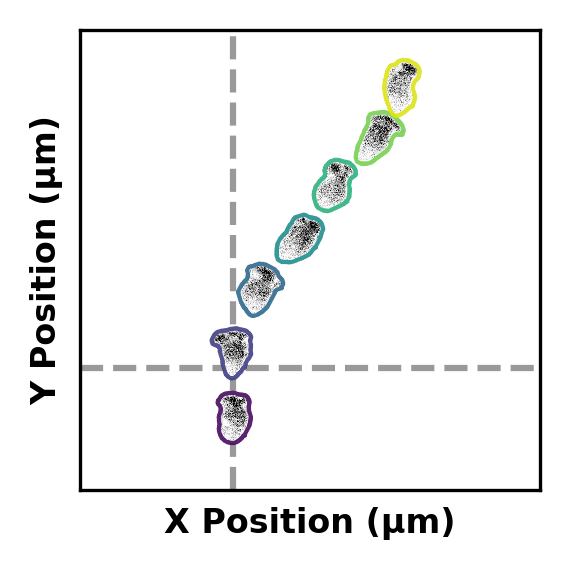

Stimulation:  global


/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


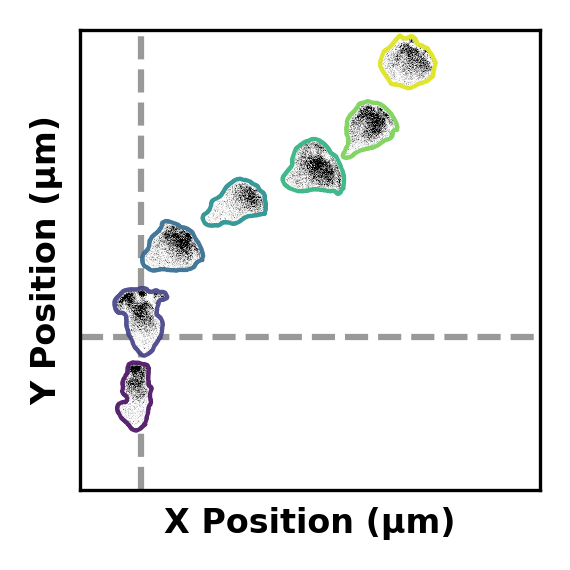

Stimulation:  front


/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


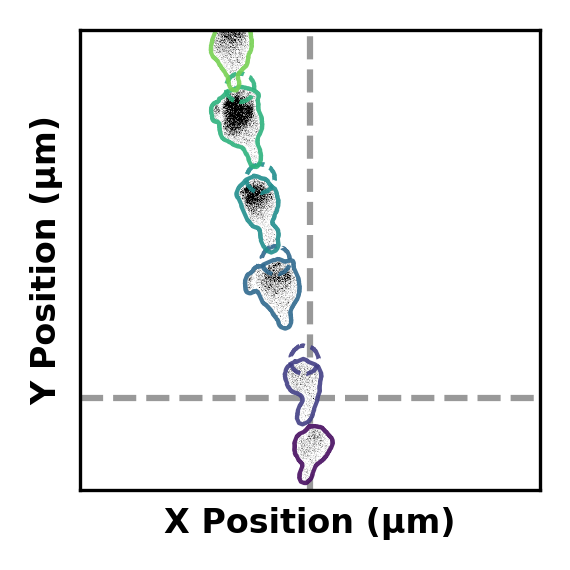

Stimulation:  side


/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


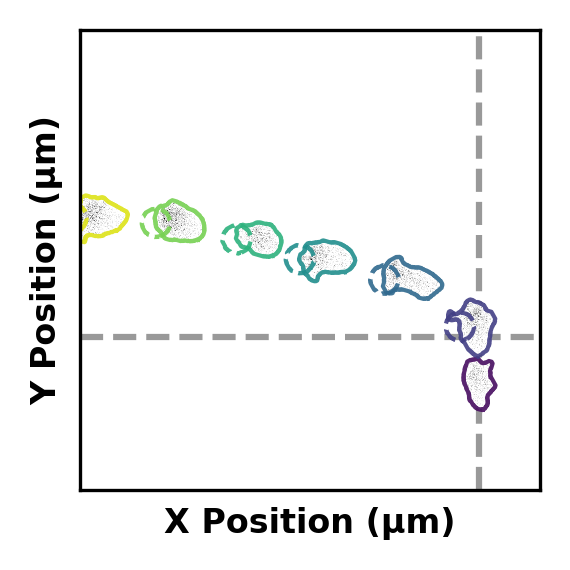

Stimulation:  back


/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


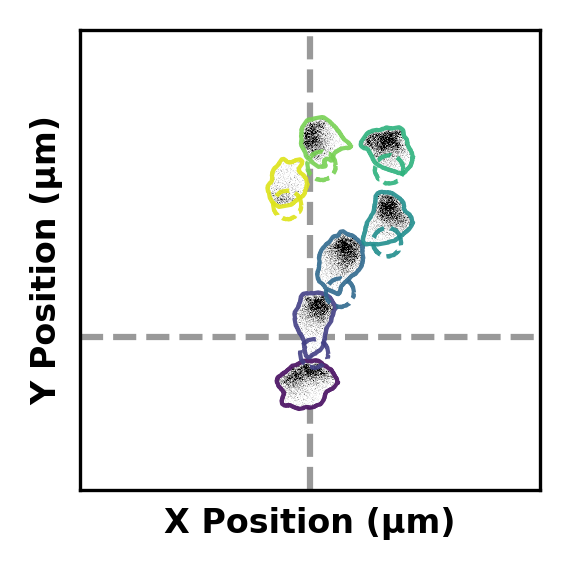

Stimulation:  lateral90


/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


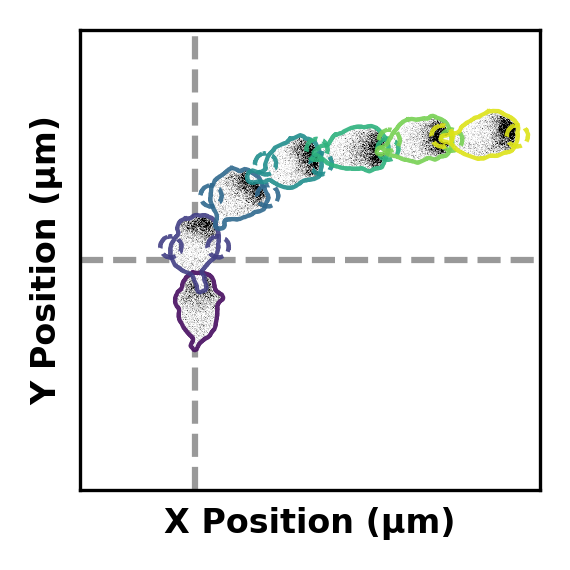

Stimulation:  lateral45


/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


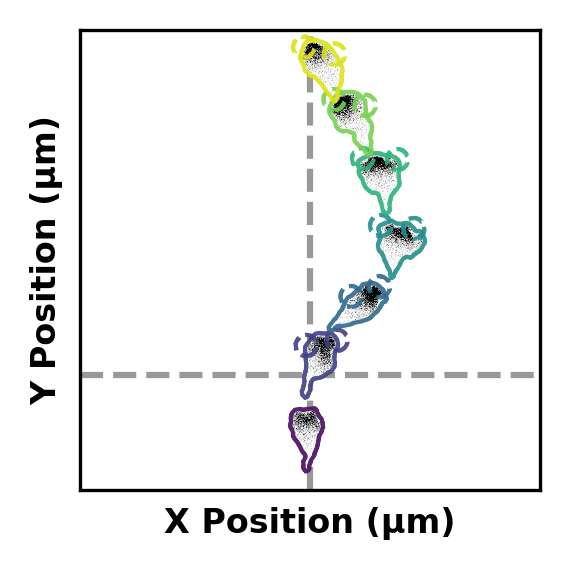

In [12]:
# paths to example single cell traces
# shown in Fig. 2C and 2G
path1 = '/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_none_50000_Intensity_001/'
path2 = '/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_001'
path3 = '/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_003/'
path4 = '/home/jason/Data/simpleStimData/220725_KWC_35-52-97_mcPak_Assays_side_50000_Intensity_006/'
path5 = '/home/jason/Data/simpleStimData/220725_KWC_35-52-97_mcPak_Assays_back_50000_Intensity_002'
path6 = '/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_004/'
path7 = '/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_001/'


# appropriate axis limits for each of the cells
ax1 = [-50, 100, -40, 110]
ax2 = [-20, 130, -50, 100]
ax3 = [-75, 75, -30, 120]
ax4 = [-130, 20, -50, 100]
ax5 = [-75, 75, -50, 100]
ax6 = [-50, 150, -100, 100]
ax7 = [-100, 100, -50, 150]

paths = [path1, path2, path3, path4, path5, path6, path7]
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
condition = ['none', 'global', 'front', 'side', 'back', 'lateral90', 'lateral45']

BY = 9 # how many frames to skip between shown stills

for count in range(7):
    
    print('Stimulation: ', condition[count])
    
    a = simpleStimData(paths[count])
    
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi = 300)

    cmap = cm.get_cmap('viridis')
    col_vec = [cmap(i) for i in np.linspace(0, 1, len(a.ch3_stack))]
    
    
    # plot the transformed pixel intensity data at the different time points
    for i in range(2, len(a.ch3_stack), BY):
        xx, yy = a.get_transformed_xy_coords(i) # rotate to standardize initial direction of cell motion
        F = a.ch0_stack[i].copy()
        F[a.ch3_stack[i] == 0] = np.nan # white-out the background
        plt.pcolormesh(xx, yy, F, vmin = 500, vmax = 900, cmap = 'Greys') #show pixel data
    
    # add outlines for segmented cell and contour of light-based activation
    # color code these based on the timing
    for i in range(2, len(a.ch3_stack), BY):
        
        # ch3 stack has segmented cell outlines
        contours = measure.find_contours(a.ch3_stack[i] > 0, level = False) 
        mat = a.transform_mats[i]
        for ctr in contours:
            y_pixel, x_pixel = ctr.T
            placeholder = np.ones_like(x_pixel)
            ctr_px = np.array([x_pixel, y_pixel, placeholder])
            y_um, x_um, placeholder = np.matmul(mat, ctr_px)
            plt.plot(x_um, y_um, color = col_vec[i], alpha = 0.9, linewidth = 1, zorder = 1)
        
        # ch4 stack has spatial light data
        contours = measure.find_contours(a.ch4_stack[i] > 0, level = False)
        mat = a.transform_mats[i]
        for ctr in contours:
            y_pixel, x_pixel = ctr.T
            placeholder = np.ones_like(x_pixel)
            ctr_px = np.array([x_pixel, y_pixel, placeholder])
            y_um, x_um, placeholder = np.matmul(mat, ctr_px)
            plt.plot(x_um, y_um, color = col_vec[i], alpha = 0.9, zorder = 1, linestyle = '--', linewidth = 1)
    
    # add axis lines at the origin - defined as the location where cells experience the first activation
    # (this is derived from the transformation matrices saved in the image metadata and is a consequence
    # of doing live-cell tracking during the experiments)
    plt.axhline(0, ls = '--', alpha = 0.4, color = 'k', zorder = -1)
    plt.axvline(0, ls = '--', alpha = 0.4, color = 'k', zorder = -1)

    # set axis limits
    plt.axis(axs[count])
    plt.xlabel('X Position (µm)', fontweight = 'bold', fontsize = 8)
    plt.ylabel('Y Position (µm)', fontweight = 'bold', fontsize = 8)
    plt.xticks([], fontsize = 5)
    plt.yticks([], fontsize = 5)

    plt.tight_layout()
    plt.show()



# Fig 2C (Bottom Row)

finding paths containing: "_side_"

/home/jason/Data/simpleStimData/220214_KWC_35-52-97_simpleStimScreen_side_50000_Intensity_000 300
/home/jason/Data/simpleStimData/220228_KWC_35-52-97_simpleStimScreen_side_50000_Intensity_000 300
/home/jason/Data/simpleStimData/220725_KWC_35-52-97_mcPak_Assays_side_50000_Intensity_005 302
/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_side_50000_Intensity_003 302
/home/jason/Data/simpleStimData/220214_KWC_35-52-97_simpleStimScreen_side_50000_Intensity_001 300
/home/jason/Data/simpleStimData/220725_KWC_35-52-97_mcPak_Assays_side_50000_Intensity_001 302
/home/jason/Data/simpleStimData/220725_KWC_35-52-97_mcPak_Assays_side_50000_Intensity_003 302
/home/jason/Data/simpleStimData/220725_KWC_35-52-97_mcPak_Assays_side_50000_Intensity_004 302
/home/jason/Data/simpleStimData/220725_KWC_35-52-97_mcPak_Assays_side_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220228_KWC_35-52-97_simpleStimScreen_well2_side_50000_Intensity_000 30

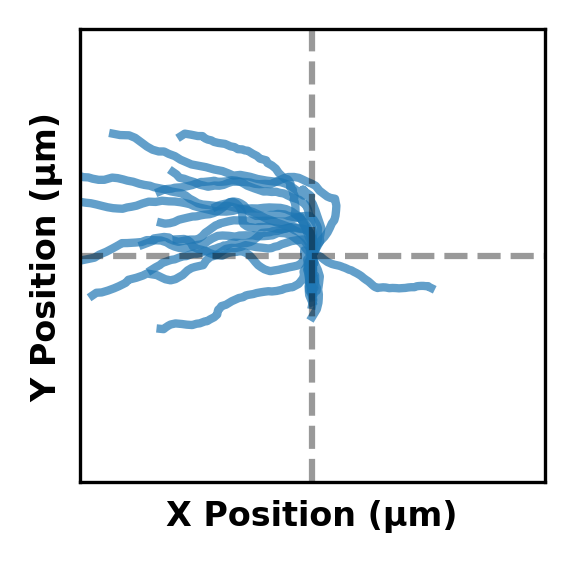

finding paths containing: "_front_"

/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_011 302
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_005 302
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_009 302
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_017 302
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_014 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_007 302
/home/jason/Data/simpleStimData/220214_KWC_35-52-97_simpleS

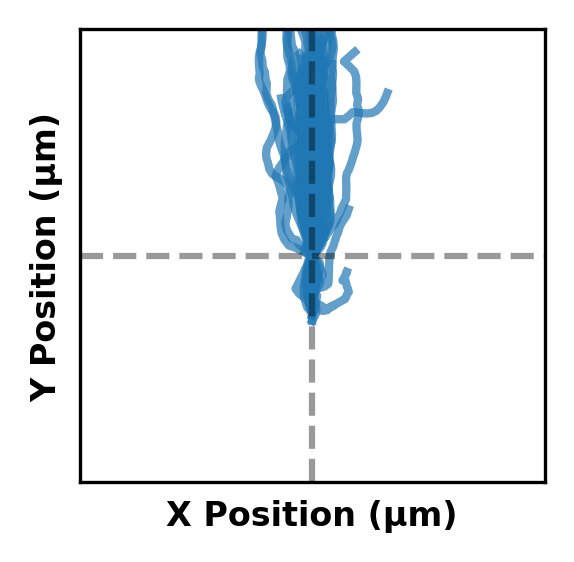

finding paths containing: "_back_"

/home/jason/Data/simpleStimData/220725_KWC_35-52-97_mcPak_Assays_back_50000_Intensity_002 302
/home/jason/Data/simpleStimData/220228_KWC_35-52-97_simpleStimScreen_well2_back_50000_Intensity_000 300
/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_back_50000_Intensity_005 302
/home/jason/Data/simpleStimData/220725_KWC_35-52-97_mcPak_Assays_back_50000_Intensity_005 302
/home/jason/Data/simpleStimData/220725_KWC_35-52-97_mcPak_Assays_back_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_back_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220725_KWC_35-52-97_mcPak_Assays_back_50000_Intensity_006 302
/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_back_50000_Intensity_004 302
/home/jason/Data/simpleStimData/220214_KWC_35-52-97_simpleStimScreen_back_50000_Intensity_000 300
/home/jason/Data/simpleStimData/220214_KWC_35-52-97_simpleStimScreen_back_50000_Intensity_00

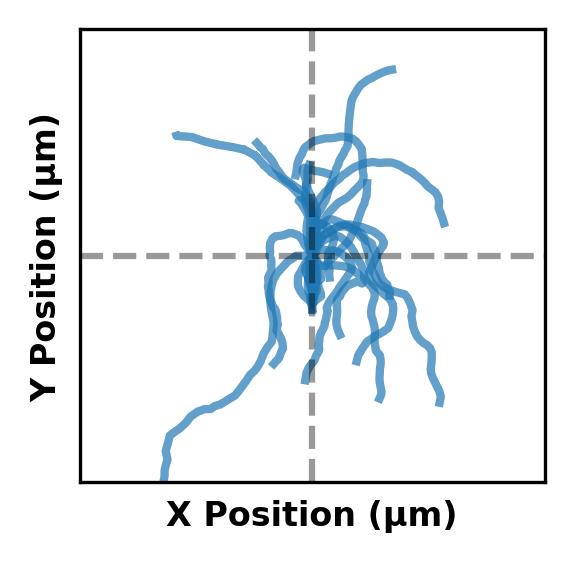

finding paths containing: "_global_"

/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_global_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_014 302
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_010 302
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_012 302
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_005 302
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_015 302
/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_global_50000_Intensity_004 302
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_003 302
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulat

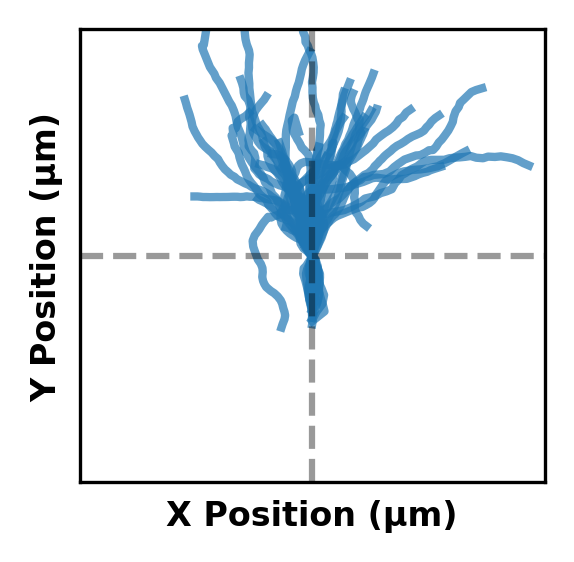

finding paths containing: "_none_"

/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_none_50000_Intensity_001 302
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_none_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_none_50000_Intensity_015 302
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_none_50000_Intensity_001 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_none_50000_Intensity_012 302
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_none_50000_Intensity_006 302
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_none_50000_Intensity_002 302
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_none_50000_Intensity_012 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations

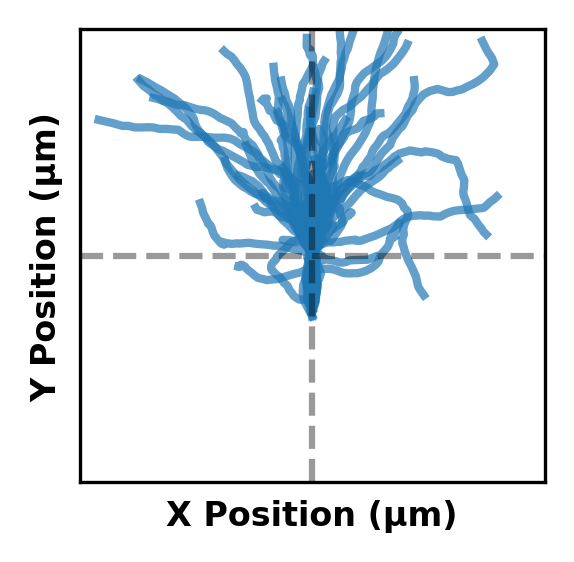

In [15]:
##################################################################################################
# Generate overlay plots of the stage coordinates for each of the sub-type of experiment
# for example, different delays or intensities for the spot introductions
# Must run code block above to identify the parent directory
##################################################################################################


different_conditions = ['_side_', '_front_', '_back_', '_global_', '_none_']


for condition in different_conditions:
    
    
    ALL_X_PATHS = []
    ALL_Y_PATHS = []

    final_lateral_pos = []
    ids = []

    print(f'finding paths containing: "{condition}"' + '\n')
    
    # collect local list of paths to experiments to pool together for display
    exp_to_analyze = []
    
    for i in DATA:
        if (condition in i):
            num_img = len(os.listdir(i))
            if num_img >= 300:
                print(i, num_img)
                exp_to_analyze.append(i)
            
    print(len(exp_to_analyze))
    
    # sort the folders alphabetically (optional)
    exp_to_analyze = np.sort(exp_to_analyze)
    

    # instantiate a figure
    plt.figure(figsize = (2, 2), dpi = 300)
    
    # loop over folders that contain the text from the list of different_conditions
    for fnum in range(len(exp_to_analyze)):
        foldername = exp_to_analyze[fnum]
        
        # collect image paths within the folder - something strange happens with some filenames and these need to be "decoded"
        try:
            im_path_list = np.sort([foldername + '/' + i for i in np.sort(os.listdir(foldername))])
        except:
            im_path_list = np.sort([foldername + '/' + i.decode('ascii') for i in np.sort(os.listdir(foldername))])
            
            
        # fluorescence channel
        ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        
        # x and y coordinates for this particular set of images
        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(ch0_path_list)):
            with tifffile.TiffFile(ch0_path_list[i]) as temptif:
                
                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)
        
        # convert to numpy arrays to make translation and rotation a little easier
        x_stage_sequence = np.array(x_stage_sequence)
        y_stage_sequence = np.array(y_stage_sequence)
        
        # calculate the initial direction of the cell in the first ten frames
        x_translated = x_stage_sequence - x_stage_sequence[10] 
        y_translated = y_stage_sequence - y_stage_sequence[10]
        rotation_angle = np.arctan2(-np.average(np.diff(y_translated[:11])), np.average(np.diff(x_translated[:11])))
        
        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - rotation_angle + math.pi/2

        x_rotated = rho * np.cos(phi)
        y_rotated = rho * np.sin(phi)

        plt.plot(x_rotated, y_rotated, alpha = 0.7, color = 'C0', lw = 2)
        ALL_X_PATHS.append(x_rotated)
        ALL_Y_PATHS.append(y_rotated)
         
    plt.axhline(0, ls = '--', color = 'k', alpha = 0.4)
    plt.axvline(0, ls = '--', color = 'k', alpha = 0.4)
    plt.axis([-125, 125, -125, 125])
    plt.xlabel('X Position (µm)', fontweight = 'bold', fontsize = 8)
    plt.ylabel('Y Position (µm)', fontweight = 'bold', fontsize = 8)
    plt.xticks([], fontsize = 5)
    plt.yticks([], fontsize = 5)
    plt.show()

# Fig. 2E

finding paths containing: "_global_"

/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_global_50000_Intensity_000
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_014
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_010
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_012
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_005
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_015
/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_global_50000_Intensity_004
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_003
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_008


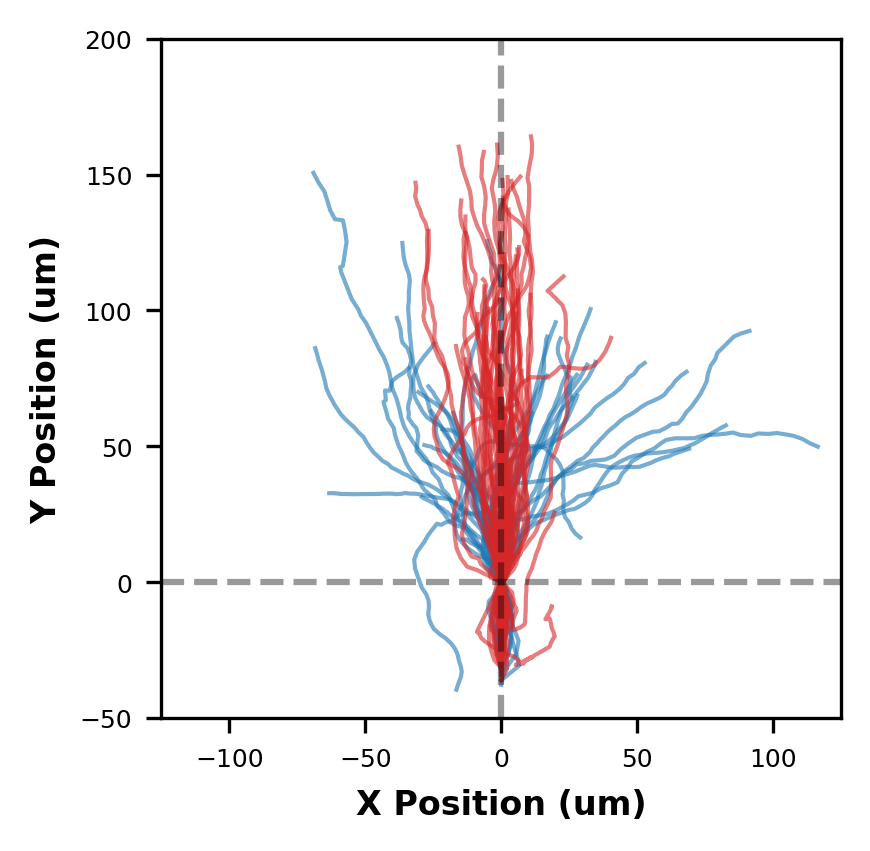

In [33]:
##################################################################################################
# Generate overlay plots of the stage coordinates for each of the sub-type of experiment
# for example, different delays or intensities for the spot introductions
# Must run code block above to identify the parent directory
##################################################################################################
plt.figure(figsize = (3, 3), dpi = 300)
ax = plt.subplot()
# select unique identifiers of the various test conditions for folders inside parent_dir
different_conditions = ['_global_', '_front_']#'lateral45_delay5_50000', 'lateral45_delay10_50000', 'lateral45_delay20_50000',  'lateral45_oneSpot_50000']

ALL_X_PATHS = []
ALL_Y_PATHS = []
    
final_lateral_pos = []
final_vertical_pos = []
ids = []


count = -1

for condition in different_conditions:
    count += 1
    
    print(f'finding paths containing: "{condition}"' + '\n')
    
    # collect local list of paths to experiments to pool together for display
    exp_to_analyze = []
    
    for i in DATA:
        if (condition in i):
            print(i)
            exp_to_analyze.append(i)
    
    # sort the folders alphabetically (optional)
    exp_to_analyze = np.sort(exp_to_analyze)
    
    
    # instantiate some containers for x and y stage coordinates
    

    # instantiate a figure
    
    
    # loop over folders that contain the text from the list of different_conditions
    for fnum in range(len(exp_to_analyze)):
        foldername = exp_to_analyze[fnum]
        
        # collect image paths within the folder
        try:
            im_path_list = np.sort([foldername + '/' + i for i in np.sort(os.listdir(foldername))])
        except:
            im_path_list = np.sort([foldername + '/' + i.decode('ascii') for i in np.sort(os.listdir(foldername))])
            
            
        ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        
        # x and y coordinates for this particular set of images
        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(ch0_path_list)):
            with tifffile.TiffFile(ch0_path_list[i]) as temptif:
                
                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)
        
        # convert to numpy arrays to make translation and rotation a little easier
        x_stage_sequence = np.array(x_stage_sequence)
        y_stage_sequence = np.array(y_stage_sequence)

        
        if condition == '_frontToGlobal_':
            # center paths on the moment of stimulation
            x_translated = x_stage_sequence - x_stage_sequence[30] 
            y_translated = y_stage_sequence - y_stage_sequence[30]
            rotation_angle = np.arctan2(-np.average(np.diff(y_translated[:11])), np.average(np.diff(x_translated[:11])))
            
        else:
            x_translated = x_stage_sequence - x_stage_sequence[10] 
            y_translated = y_stage_sequence - y_stage_sequence[10]
            rotation_angle = np.arctan2(-np.average(np.diff(y_translated[:11])), np.average(np.diff(x_translated[:11])))
            
        # calculate the initial direction of the cell in the first ten frames
        
        
        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - rotation_angle + math.pi/2

        x_rotated = rho * np.cos(phi)
        y_rotated = rho * np.sin(phi)


        plt.subplot(aspect = 'equal')

        if condition == '_none_':
            plt.plot(x_rotated, y_rotated, color = 'C0', alpha = 0.6, lw = 1)
            #plt.scatter(x_rotated[-1], y_rotated[-1], color = 'C0', alpha = 0.8)
            final_lateral_pos.append(x_rotated[-1])
            final_vertical_pos.append(y_rotated[-1])
            ids.append(0)
            
        elif condition == '_global_':
            plt.plot(x_rotated, y_rotated, color = 'C0', alpha = 0.6, lw = 1)
            #plt.scatter(x_rotated[-1], y_rotated[-1], color = 'C0', alpha = 0.8)
            final_lateral_pos.append(x_rotated[-1])
            final_vertical_pos.append(y_rotated[-1])
            ids.append(1)
            
        else:
            plt.plot(x_rotated, y_rotated, color = 'C3', alpha = 0.6, lw = 1)
            #plt.scatter(x_rotated[-1], y_rotated[-1], color = 'C1', alpha = 0.8)
            final_lateral_pos.append(x_rotated[-1])
            final_vertical_pos.append(y_rotated[-1])
            ids.append(2)
            

        ALL_X_PATHS.append(x_rotated)
        ALL_Y_PATHS.append(y_rotated)
    
plt.axhline(0, ls = '--', color = 'k', alpha = 0.4)
plt.axvline(0, ls = '--', color = 'k', alpha = 0.4)
plt.axis([-125, 125, -50, 200])
plt.xlabel('X Position (um)', fontweight = 'bold', fontsize = 8)
plt.ylabel('Y Position (um)', fontweight = 'bold', fontsize = 8)
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)
plt.show()


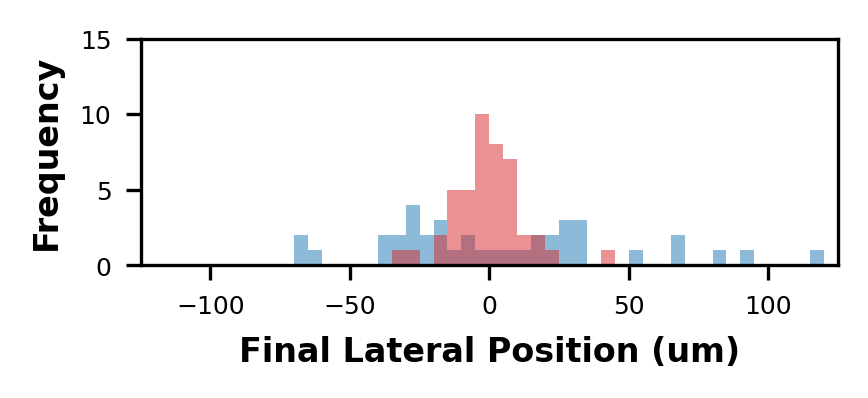

LeveneResult(statistic=37.04630623535804, pvalue=3.535258368250812e-08)


In [39]:

flp = np.array(final_lateral_pos)
fvp = np.array(final_vertical_pos)
ids = np.array(ids)
A = np.arctan2(-fvp, flp)


plt.figure(figsize = (3, 1), dpi = 300)
B = np.linspace(-125, 125, 51)
plt.hist(flp[ids == 1], alpha = 0.5, bins = B)
plt.hist(flp[ids == 2], alpha = 0.5, bins = B, color = 'C3')
plt.xlabel('Final Lateral Position (um)', fontsize = 8, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 8, fontweight = 'bold')
plt.xticks(size = 6)
plt.yticks([0, 5, 10, 15], size = 6)
plt.axis([-125, 125, 0, 15])
plt.show()

print(levene(flp[ids == 1], flp[ids == 2]))

# Fig. 2D

_0Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_003
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_013
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_007
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_016
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_005
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_004
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_009
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_012
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_006
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_014
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_015
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_010
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_002
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_017


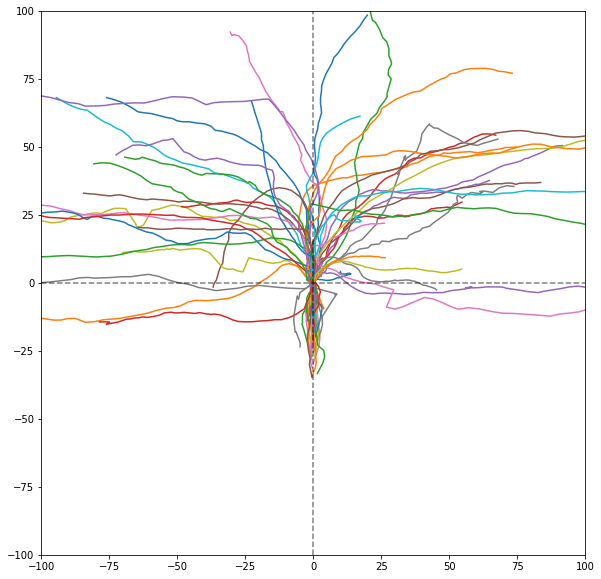

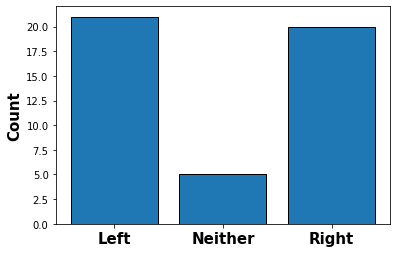

0.4878048780487805
_0.2Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_016
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_003
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_008
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_002
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_013
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_015
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_006
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_017
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_009
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_007
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_018
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_004
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_011
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_005
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_012
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_010
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_000


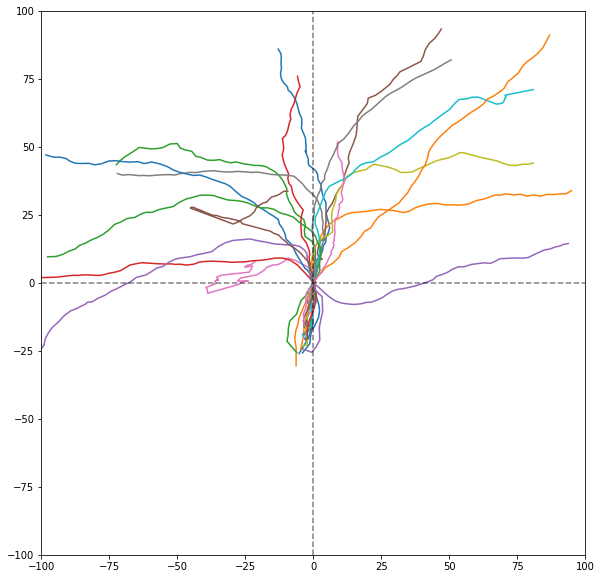

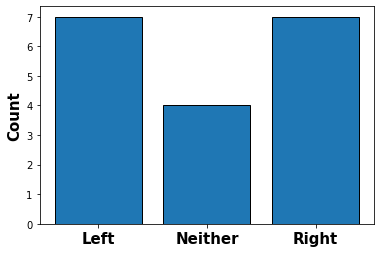

0.5
_0.39Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_013
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_011
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_003
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_000
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_014
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_006
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_007
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_012
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_009
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_008
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_016
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.39Rad_010


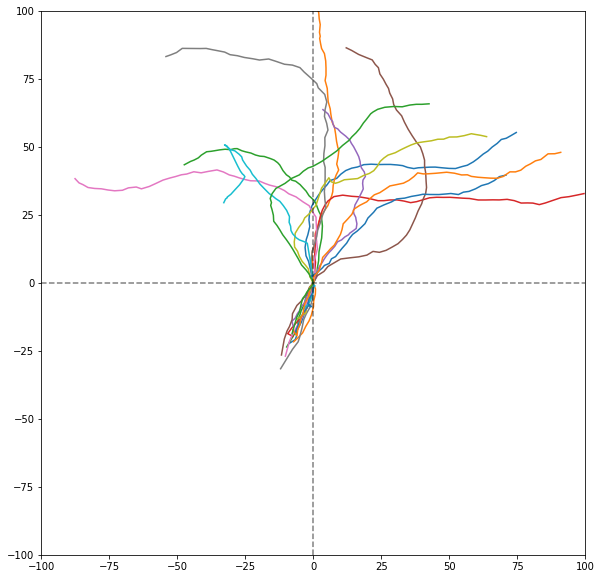

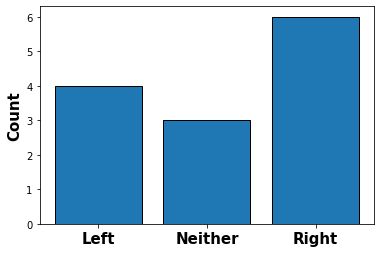

0.6
_0.79Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_004
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_009
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_000
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_008
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_013
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_010
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_002
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_011
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_007
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_016
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_015
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.79Rad_006


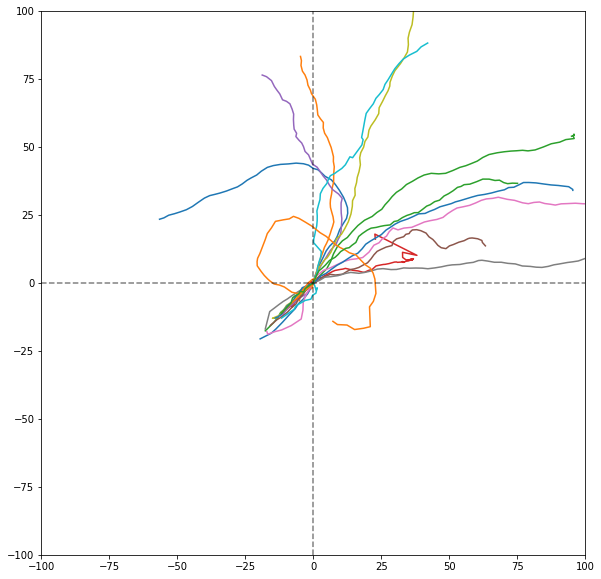

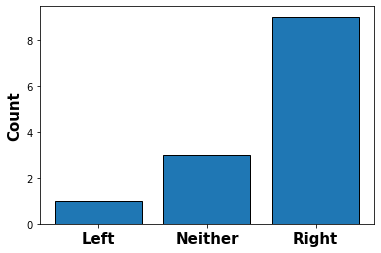

0.9
_1.57Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_005
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_000
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_003
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_004
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_1.57Rad_009


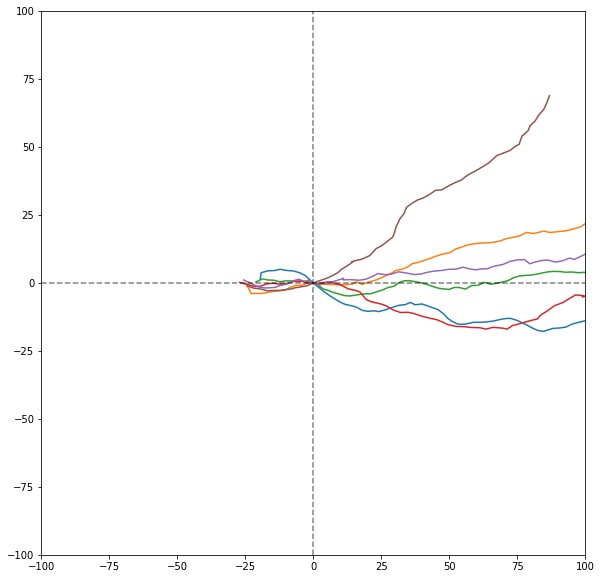

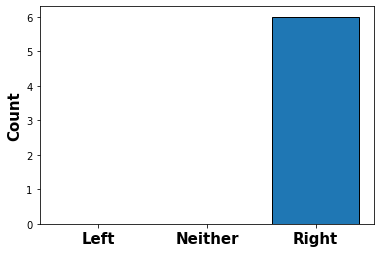

1.0


In [16]:
proportions_across_data = []
num_turning = []


angles = np.array([0, math.pi/16, math.pi/8, math.pi/4, math.pi/2])

count = 0
for delay in [ '_0Rad_', '_0.2Rad_', '_0.39Rad_', '_0.79Rad_', '_1.57Rad_']:
    
    print(delay)
    
    
    exp_to_analyze = []

    parent_dir = '/home/jason/Data/simpleStimData/'
    for i in os.listdir(parent_dir):
        if (delay in i):
            print(i)
            exp_to_analyze.append(parent_dir + i)
            
        # special case because of messy naming: for 0Rad case, include other lateral 90 experiments
        if delay == '_0Rad_':
            if '_lateral90_50000' in i:
                exp_to_analyze.append(parent_dir + i)
                    
    exp_to_analyze = np.sort(exp_to_analyze)

    ALL_X_PATHS = []
    ALL_Y_PATHS = []


    plt.figure(figsize = (10, 10))
    
    
    
    for fnum in range(len(exp_to_analyze)):
        foldername = exp_to_analyze[fnum]

        im_path_list = np.sort([foldername + '/' + i.decode('ascii') for i in np.sort(os.listdir(foldername))])
        ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])

        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(ch0_path_list)):
            with tifffile.TiffFile(ch0_path_list[i]) as temptif:
                #plt.imshow(temptif.asarray())

                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)

        x_stage_sequence = np.array(x_stage_sequence)
        y_stage_sequence = np.array(y_stage_sequence)

        x_translated = x_stage_sequence - x_stage_sequence[10] 
        y_translated = y_stage_sequence - y_stage_sequence[10]

        rotation_angle = np.arctan2(-np.average(np.diff(y_translated[:10])), np.average(np.diff(x_translated[:10])))

        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - rotation_angle + math.pi/2 - angles[count]

        x_rotated = rho * np.cos(phi)
        y_rotated = rho * np.sin(phi)


        plt.subplot(aspect = 'equal')
        plt.plot(x_rotated, y_rotated)

        ALL_X_PATHS.append(x_rotated)
        ALL_Y_PATHS.append(y_rotated)
        
    xvals = np.linspace(-100, 100, 100)
    yvals = np.tan(angles[count]) * xvals
    
    #plt.plot(xvals, yvals, color = 'k', ls = '--')
    
    plt.axis([-100, 100, -100, 100])
    plt.axhline(0, ls = '--', alpha = 0.5, color = 'k')
    plt.axvline(0, ls = '--', alpha = 0.5, color = 'k')
    plt.show()

    final_loc = np.array([i[-1] for i in ALL_X_PATHS])

    cutoff = 20

    left = np.sum(final_loc < -cutoff)
    neither = np.sum(np.abs(final_loc) < cutoff)
    right = np.sum(final_loc > cutoff)

    plt.bar([0, 1, 2], [left, neither, right], ec= 'k')
    plt.xticks([0, 1, 2], ['Left', 'Neither', 'Right'], fontweight = 'bold', fontsize = 15)
    plt.ylabel('Count', fontweight = 'bold', fontsize = 15)
    
    plt.show()
    
    
    
    proportion_right = right/(left + right)
    
    print(proportion_right)
    
    proportions_across_data.append(proportion_right)
    num_turning.append(left + right)
    
    count += 1
    
    
proportions_across_data = np.array(proportions_across_data)

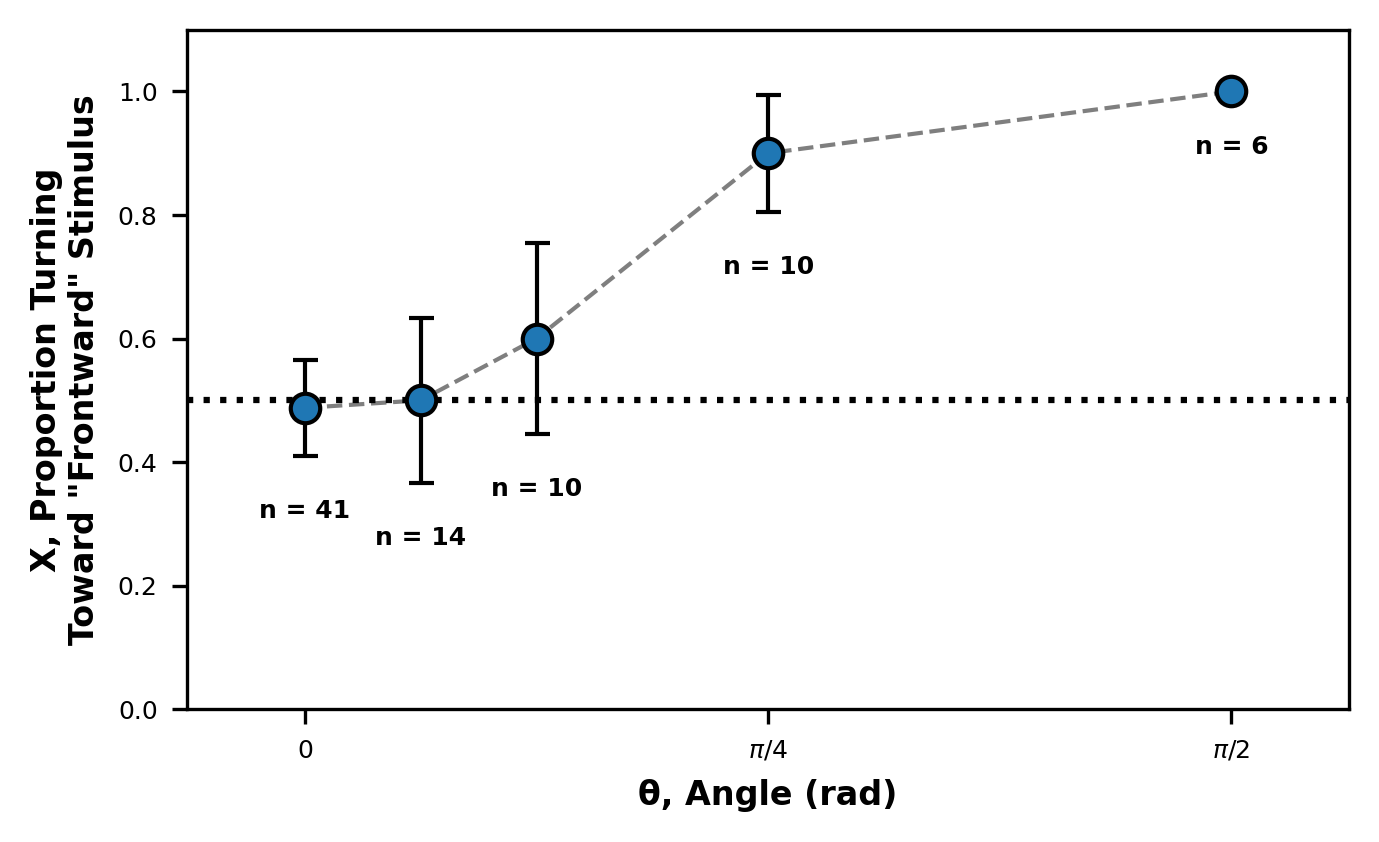

0.0 Rad, X: 0.49
0.2 Rad, X: 0.5
0.39 Rad, X: 0.6
0.79 Rad, X: 0.9
1.57 Rad, X: 1.0


In [30]:
#Standard Error of Sample Proportion
sample_error = np.sqrt(proportions_across_data * (1 - proportions_across_data) / num_turning)
percent_confidence_interval_95 = 1.96 * sample_error


plt.figure(figsize = (5, 3), dpi = 300)
ax = plt.subplot()
plt.scatter(angles, proportions_across_data, zorder = 1, s = 50, lw = 1, ec = 'k')
plt.plot(angles, proportions_across_data, zorder = 0, alpha = 0.5, lw = 1, color = 'k', ls = '--')
plt.errorbar(angles, proportions_across_data, sample_error, color = 'k', zorder = 0, lw = 1, capsize = 3, ls = 'none')

for i in range(len(proportions_across_data)):
    ax.text(angles[i], proportions_across_data[i] -sample_error[i] - 0.1, f'n = {num_turning[i]}', ha = 'center', fontweight = 'bold', fontsize = 6)
plt.xlabel('θ, Angle (rad)', fontweight = 'bold', fontsize = 8)
plt.ylabel('X, Proportion Turning\nToward "Frontward" Stimulus', fontweight = 'bold', fontsize = 8)
plt.ylim(0.0, 1.1)
plt.xlim(-0.2, math.pi/2 + 0.2)
plt.xticks([0, math.pi/4, math.pi/2], [r'$0$', r'$\pi/4$', r'$\pi/2$'], fontsize = 6)
plt.yticks(fontsize = 6)
plt.axhline(0.5, ls = ':', color = 'k', zorder = -1)
plt.show()

for i, p in enumerate(proportions_across_data):
    print(str(np.round(angles[i], 2)) + ' Rad,', 'X: ' + str(np.round(p, 2)))

# Fig 2F

In [40]:
parent = '/home/jason/Data/simpleStimData/'

global_ch0_frontback = []
global_ch1_frontback = []

ch0_avg_dynamics = []
ch1_avg_dynamics = []

for fname in os.listdir(parent):
    if '_global_' in fname:
        a = simpleStimData(parent + fname)
        a.calculate_frontbackSignals()
        global_ch0_frontback.append(a.ch0_frontback)
        global_ch1_frontback.append(a.ch1_frontback)
        
        a.calculate_global_dynamics()
        ch0_avg_dynamics.append(a.ch0_dynamics)
        ch1_avg_dynamics.append(a.ch1_dynamics)
        
global_ch0_frontback = np.array(global_ch0_frontback)
global_ch1_frontback = np.array(global_ch1_frontback)

/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/jason/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jason/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


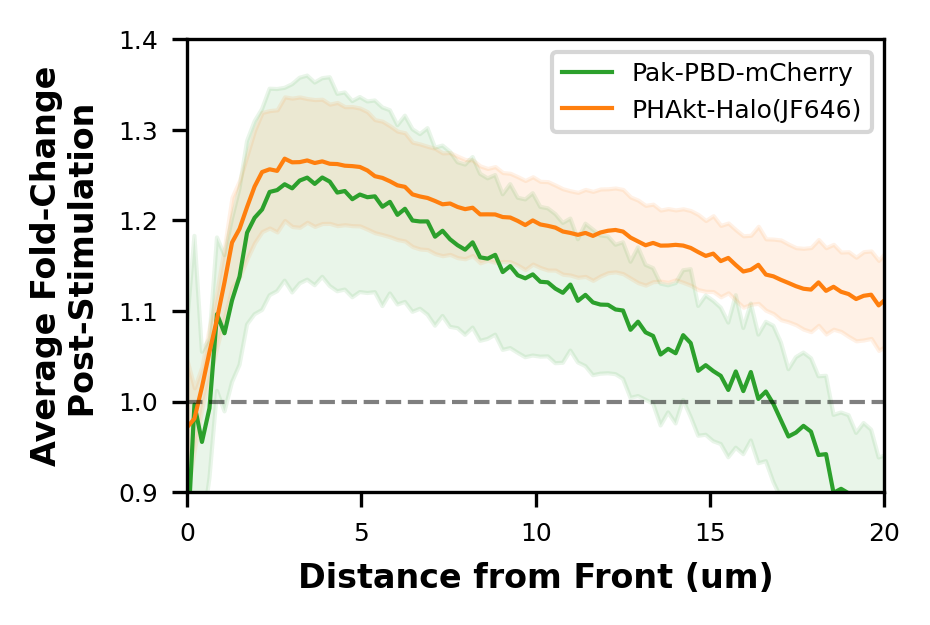

In [46]:
global_ch0_frontback_basenorm = np.array([i/np.nanmean(i[:10]) for i in global_ch0_frontback])
global_ch1_frontback_basenorm = np.array([i/np.nanmean(i[:10]) for i in global_ch1_frontback])

ch0_globalstim_frontback_avg = np.nanmean(global_ch0_frontback_basenorm, axis = 0)
ch1_globalstim_frontback_avg = np.nanmean(global_ch1_frontback_basenorm, axis = 0)

ch0_basal_spatial = np.average(ch0_globalstim_frontback_avg[:10], axis = 0)
ch1_basal_spatial = np.average(ch1_globalstim_frontback_avg[:10], axis = 0)


FC_ch0 = [i/ch0_basal_spatial for i in ch0_globalstim_frontback_avg]
FC_ch1 = [i/ch1_basal_spatial for i in ch1_globalstim_frontback_avg]

m0 = np.average(FC_ch0[10:], axis = 0)
m1 = np.average(FC_ch1[10:], axis = 0)
s0 = np.std(FC_ch0[10:], axis = 0)
s1 = np.std(FC_ch1[10:], axis = 0)

plt.figure(figsize = (3, 2), dpi = 300)
x = np.arange(100) * 0.2156 # pixel size is .2156 microns
plt.plot(x, m0, lw = 1, label = 'Pak-PBD-mCherry', color = 'C2')
plt.fill_between(x, m0 - s0, m0 + s0, alpha = 0.1, color = 'C2')
plt.plot(x, m1, lw = 1, label = 'PHAkt-Halo(JF646)', color = 'C1')
plt.fill_between(x, m1 - s1, m1 + s1, alpha = 0.1, color = 'C1')

plt.ylim(0.9, 1.4)
plt.xlim(0, 20)
plt.axhline(1, ls = '--', lw = 1, color = 'k', alpha = 0.5)
plt.ylabel('Average Fold-Change\n Post-Stimulation', fontweight = 'bold', fontsize = 8)
plt.xlabel('Distance from Front (um)', fontweight = 'bold', fontsize = 8)
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)
plt.legend(prop={'size': 6})
plt.show()



# Fig. S2

finding paths containing: "_lateral90_50000_"

/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_002 302
/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_lateral90_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_003 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_011 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_009 302
/home/jason/Data/simpleStimData/220228_KWC_35-52-97_simpleStimScreen_well2_lateral90_50000_Intensity_000 300
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_004 302
/home/jason/Data/simpleStimData/220704_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_001 302
/home/jason/Data/simpleStimData/220628_

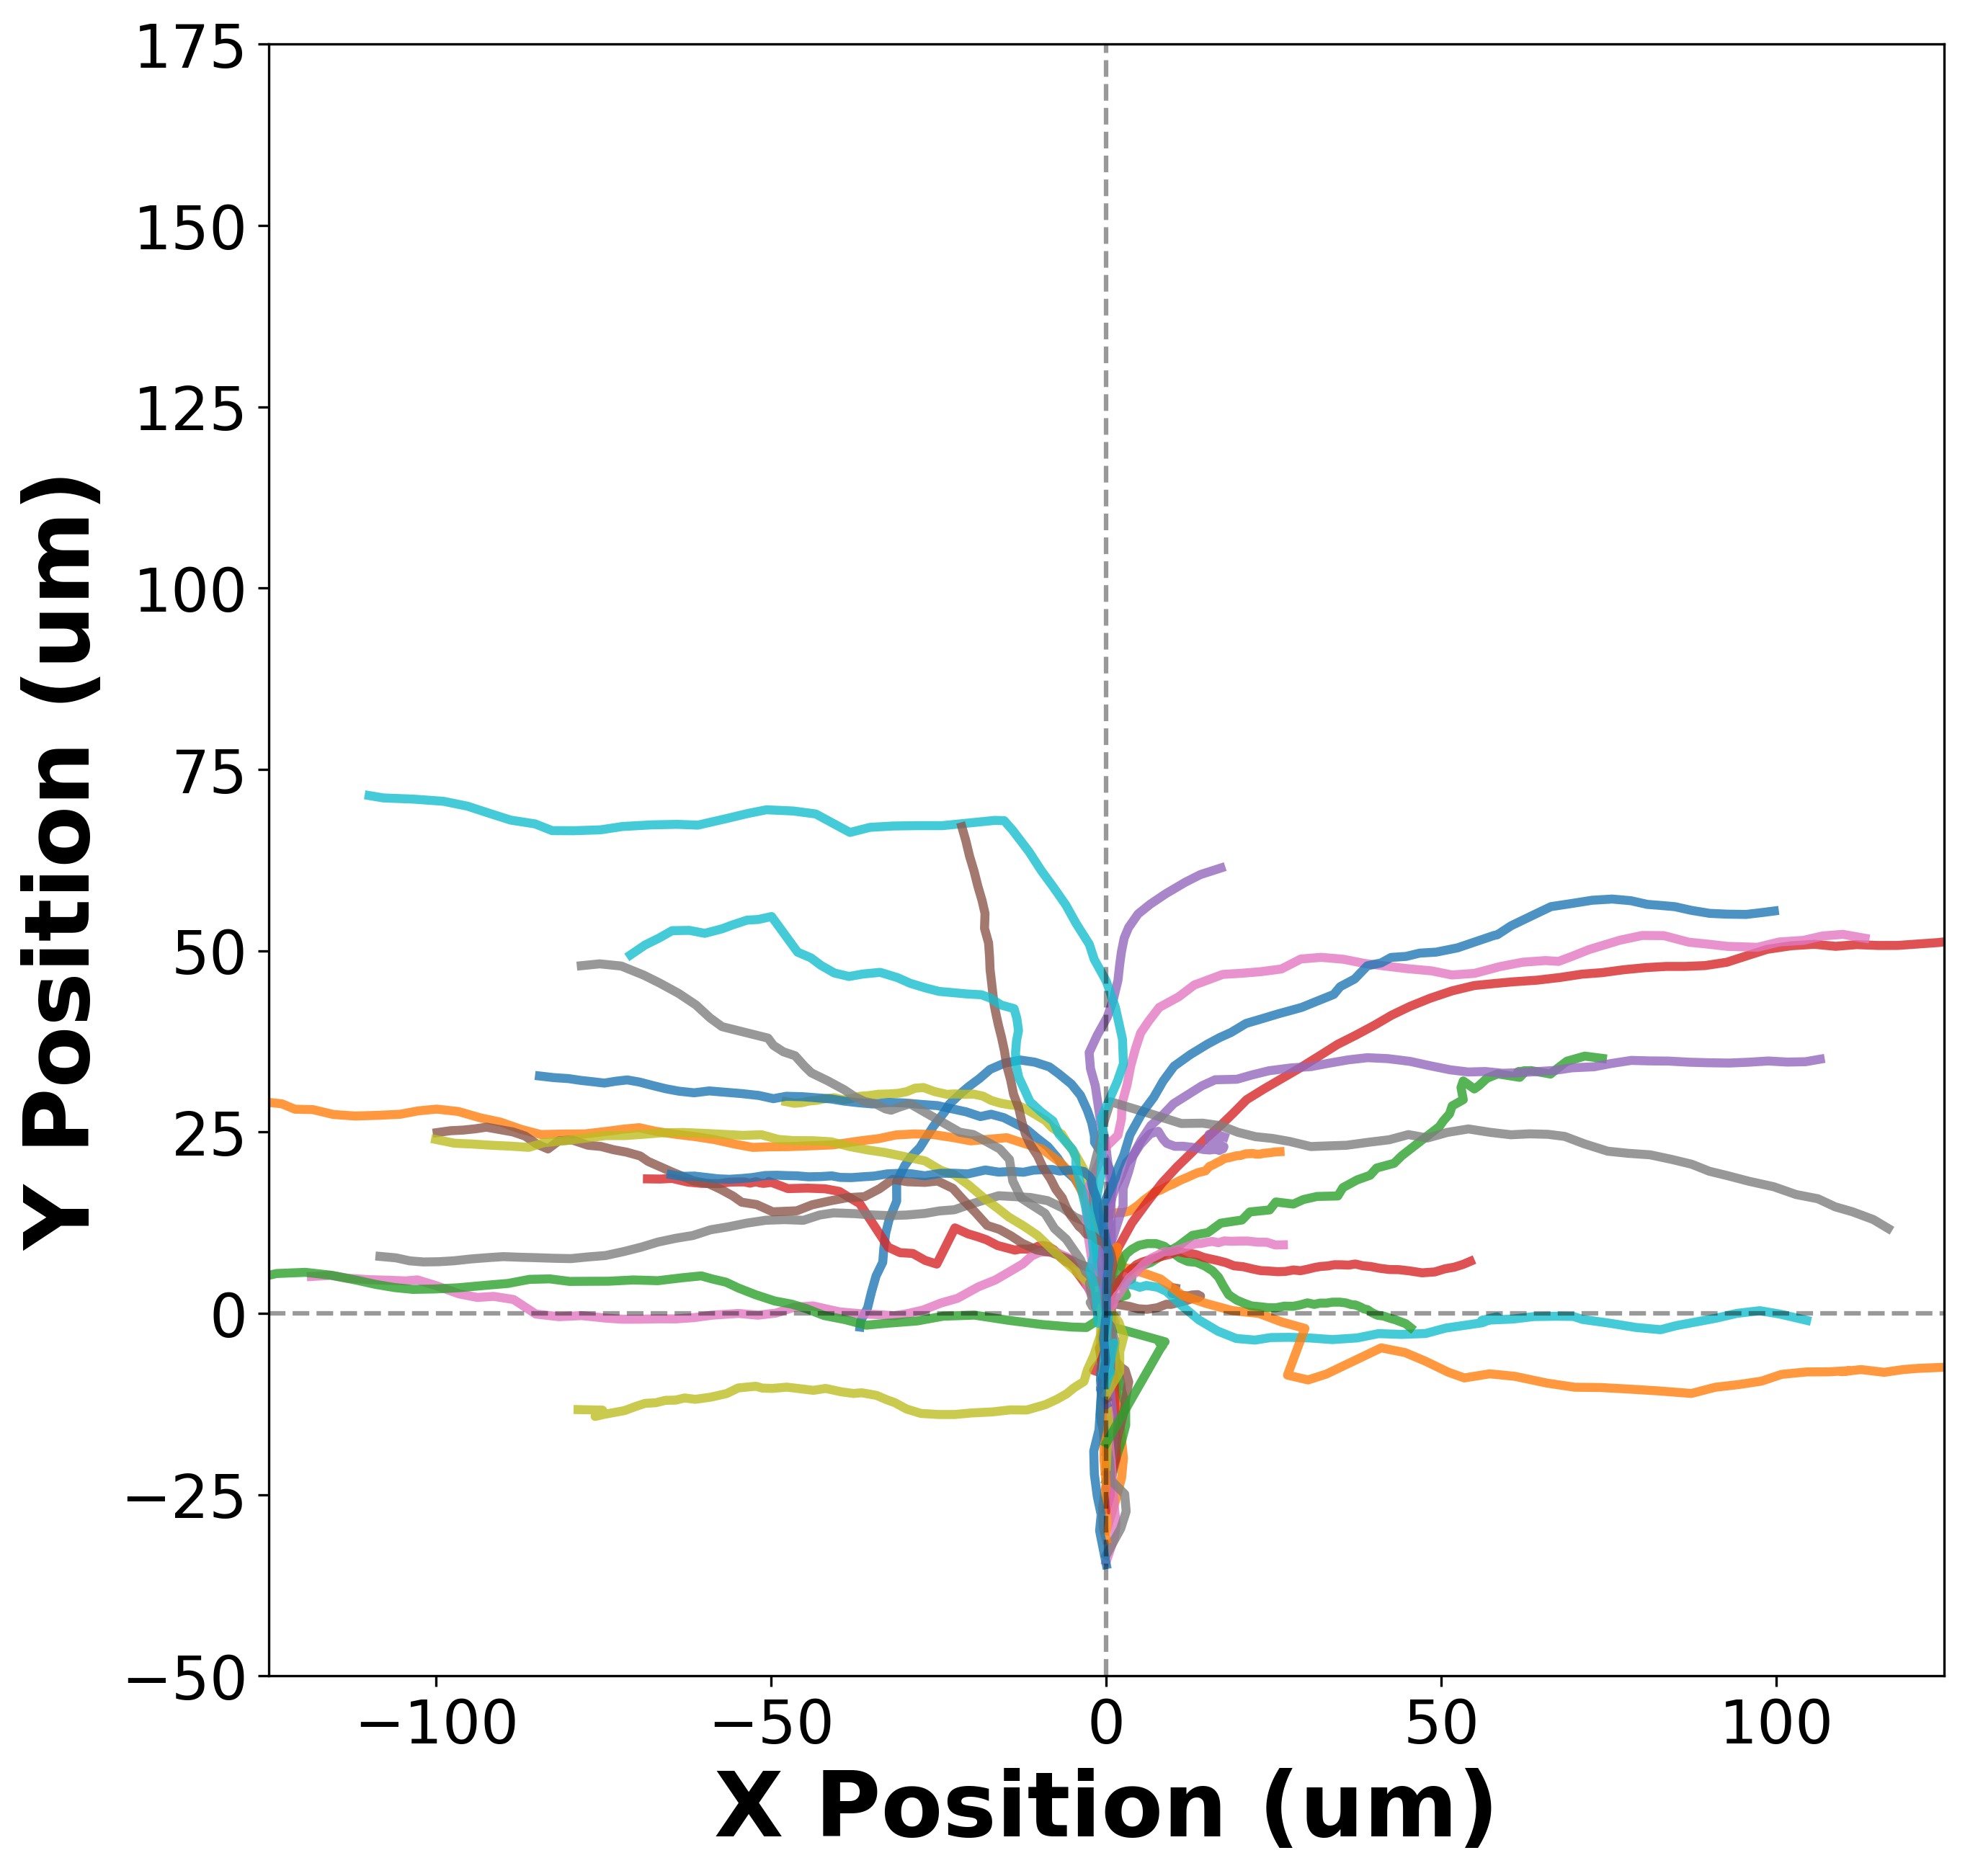

finding paths containing: "_lateral45_50000_"

/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_012 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220704_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_014 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_016 302
/home/jason/Data/simpleStimData/220704_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_007 302
/home/jason/Data/simpleStimData/220704_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_002 302
/home/jason/Data/simpleStimData/220704_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_005 302
/home/jason/Data/

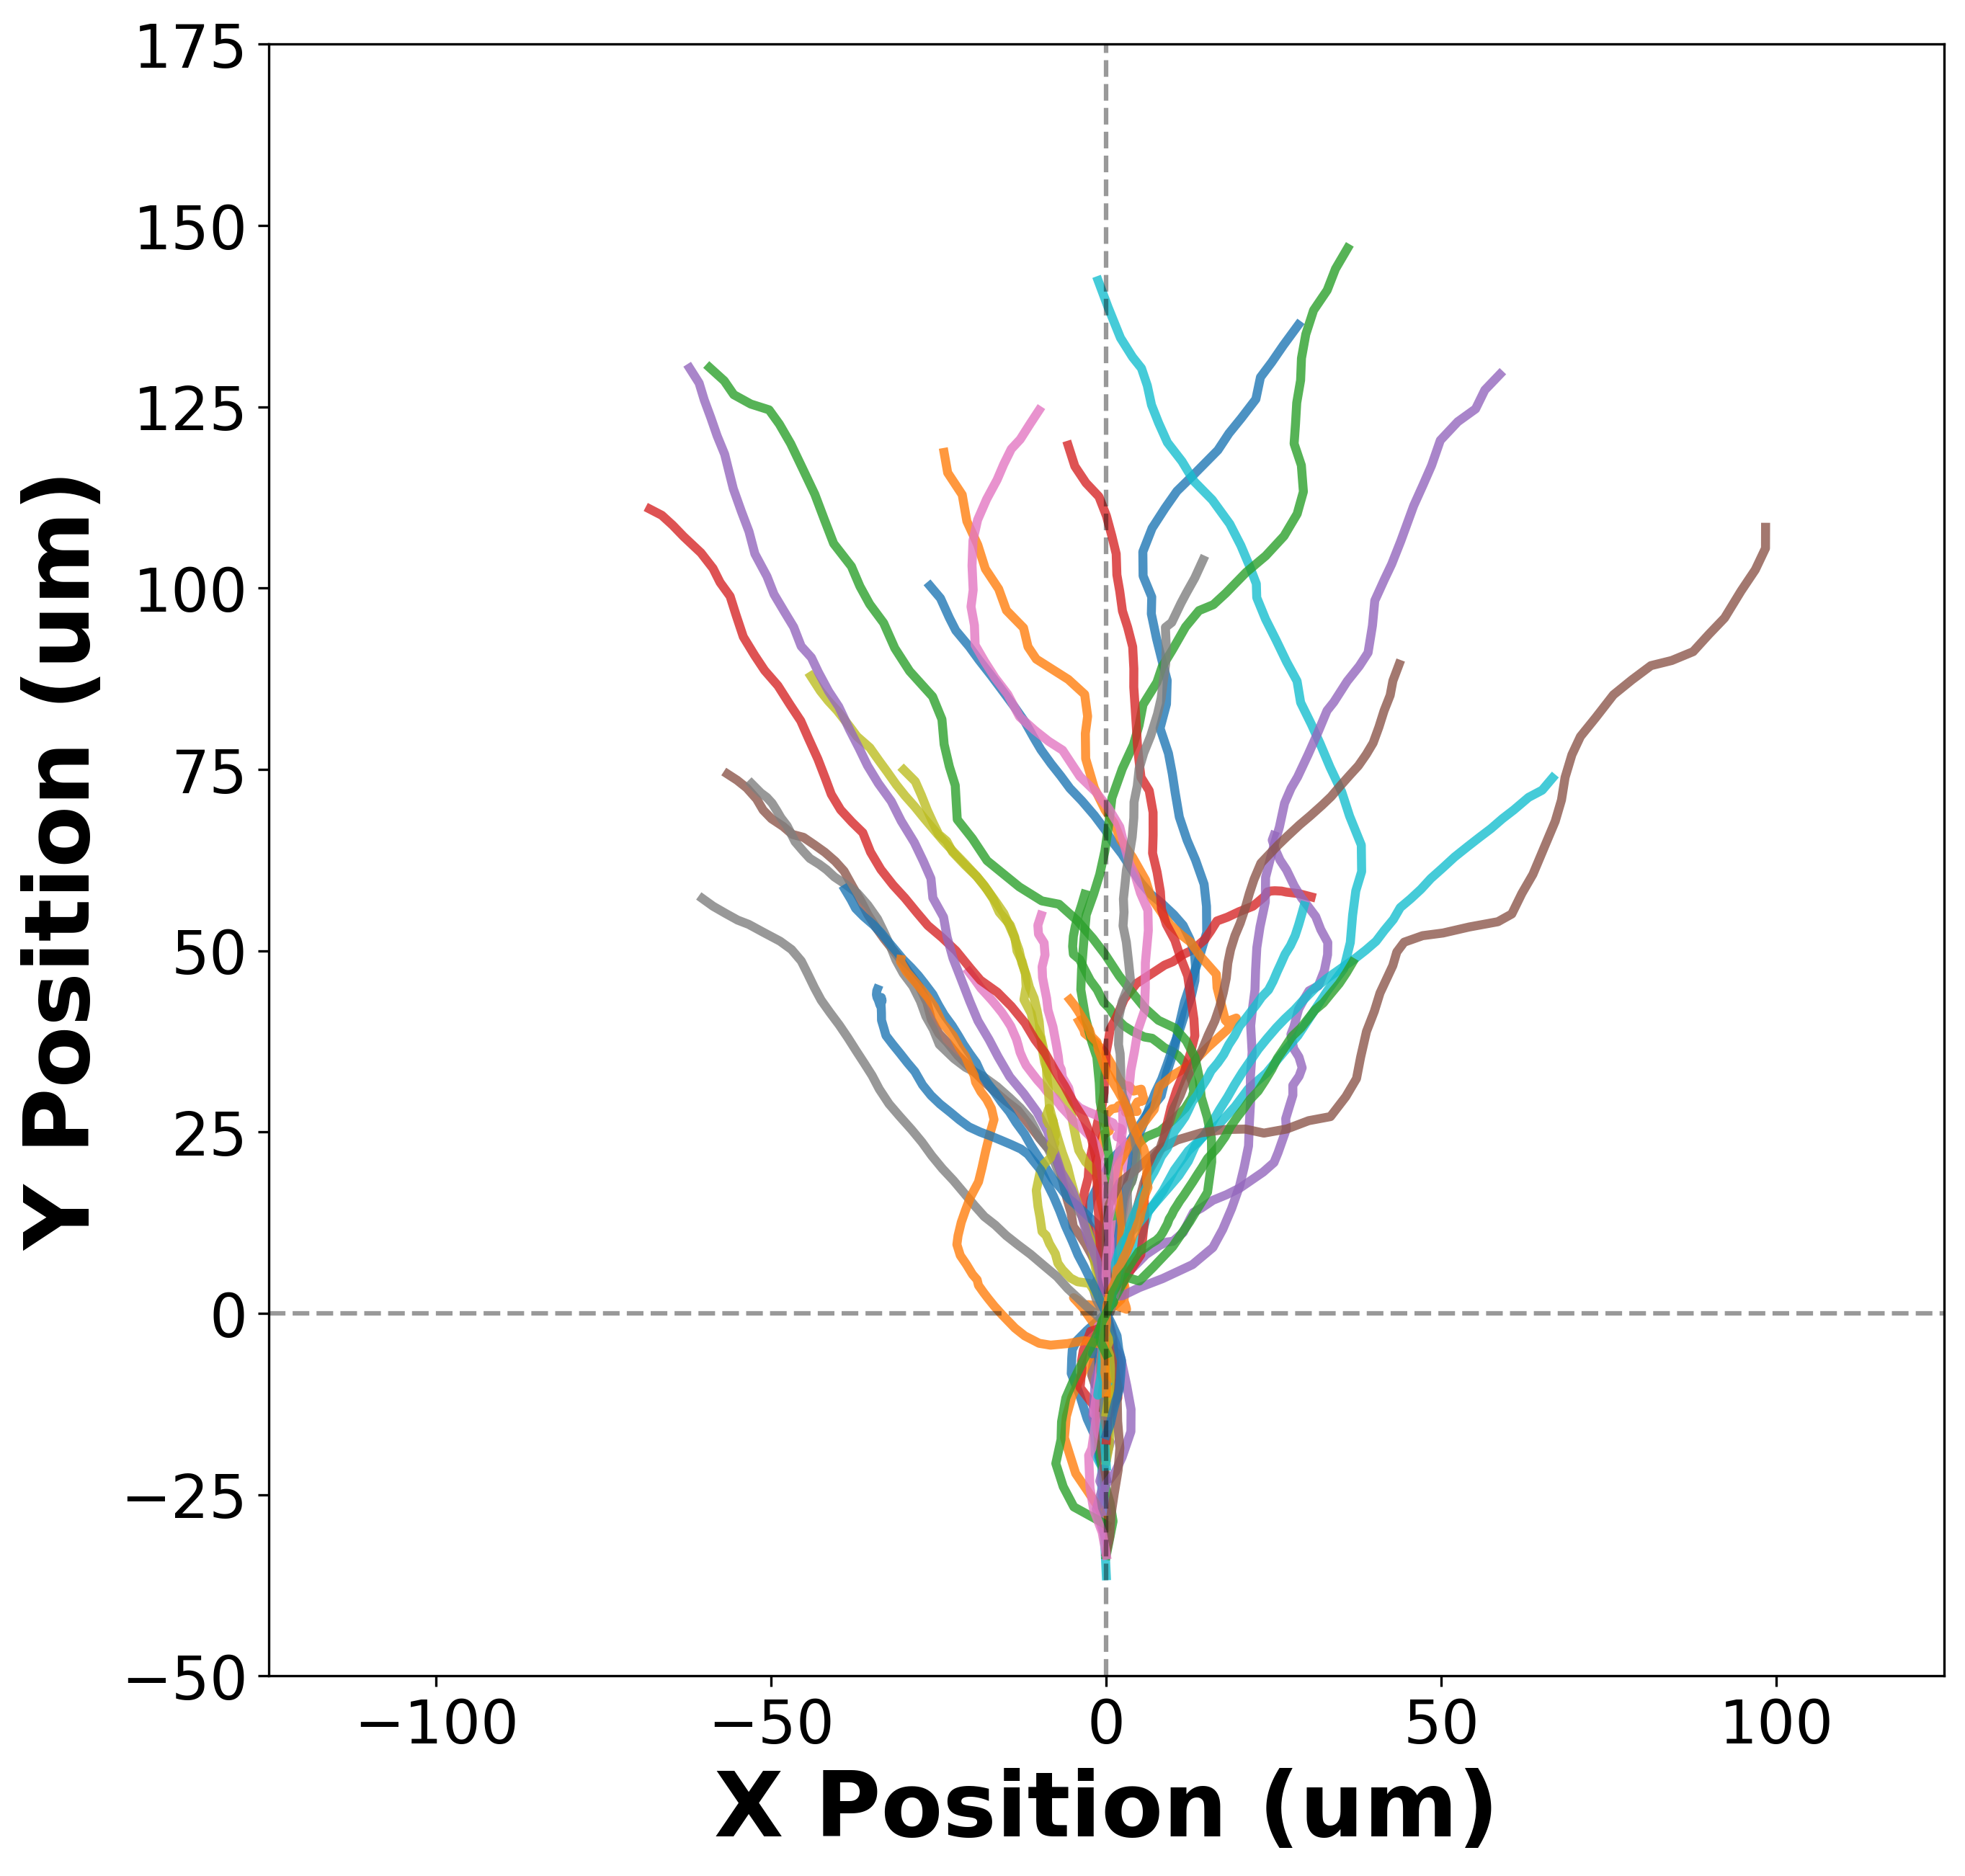

In [48]:
##################################################################################################
# Generate overlay plots of the stage coordinates for each of the sub-type of experiment
# for example, different delays or intensities for the spot introductions
# Must run code block above to identify the parent directory
##################################################################################################

# select unique identifiers of the various test conditions for folders inside parent_dir
different_conditions = ['_lateral90_50000_', '_lateral45_50000_']


for condition in different_conditions:
    
    
    ALL_X_PATHS = []
    ALL_Y_PATHS = []

    final_lateral_pos = []
    ids = []

    print(f'finding paths containing: "{condition}"' + '\n')
    
    # collect local list of paths to experiments to pool together for display
    exp_to_analyze = []
    
    for i in DATA:
        if (condition in i):
            num_img = len(os.listdir(i))
            if num_img >= 300:
                print(i, num_img)
                exp_to_analyze.append(i)
            
    print(len(exp_to_analyze))
    
    # sort the folders alphabetically (optional)
    exp_to_analyze = np.sort(exp_to_analyze)
    

    # instantiate a figure
    plt.figure(figsize = (10, 10), dpi = 300)
    
    # loop over folders that contain the text from the list of different_conditions
    for fnum in range(len(exp_to_analyze)):
        foldername = exp_to_analyze[fnum]
        
        # collect image paths within the folder
        try:
            im_path_list = np.sort([foldername + '/' + i for i in np.sort(os.listdir(foldername))])
        except:
            im_path_list = np.sort([foldername + '/' + i.decode('ascii') for i in np.sort(os.listdir(foldername))])
            
            
        ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        
        # x and y coordinates for this particular set of images
        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(ch0_path_list)):
            with tifffile.TiffFile(ch0_path_list[i]) as temptif:
                
                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)
        
        # convert to numpy arrays to make translation and rotation a little easier
        x_stage_sequence = np.array(x_stage_sequence)
        y_stage_sequence = np.array(y_stage_sequence)
        
        # calculate the initial direction of the cell in the first ten frames
        x_translated = x_stage_sequence - x_stage_sequence[10] 
        y_translated = y_stage_sequence - y_stage_sequence[10]
        rotation_angle = np.arctan2(-np.average(np.diff(y_translated[:11])), np.average(np.diff(x_translated[:11])))
        
        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - rotation_angle + math.pi/2

        x_rotated = rho * np.cos(phi)
        y_rotated = rho * np.sin(phi)

        plt.plot(x_rotated, y_rotated, alpha = 0.8, lw = 3)
        ALL_X_PATHS.append(x_rotated)
        ALL_Y_PATHS.append(y_rotated)
        
    #plt.plot(np.average(ALL_X_PATHS, axis = 0), np.average(ALL_Y_PATHS, axis = 0), c = 'C0', lw = 6)
    
    plt.axhline(0, ls = '--', color = 'k', alpha = 0.4)
    plt.axvline(0, ls = '--', color = 'k', alpha = 0.4)
    plt.axis([-125, 125, -50, 175])
    plt.xlabel('X Position (um)', fontweight = 'bold', fontsize = 30)
    plt.ylabel('Y Position (um)', fontweight = 'bold', fontsize = 30)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()
    
    
    
    if condition == '_lateral90_50000_':
        X_90 = ALL_X_PATHS.copy()
        Y_90 = ALL_Y_PATHS.copy()
    if condition == '_lateral45_50000_':
        X_45 = ALL_X_PATHS.copy()
        Y_45 = ALL_Y_PATHS.copy()

# Fig. 2G (Top)

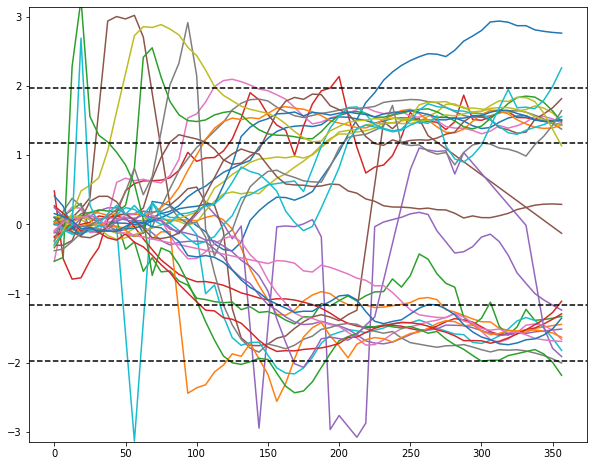

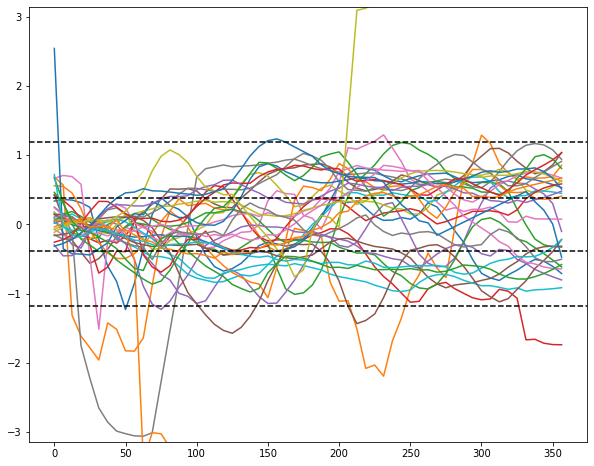

In [49]:

RAD_CUTOFF = 0.4
SPD_CUTOFF = 2

plt.figure(figsize = (10, 8))
N = 10

T = 6.25*np.arange(len(X_90[N]))
X = np.array([X_90[N], Y_90[N]]).T

xprime = [savgol_filter(X_90[N], 9, 3) for N in range(len(X_90))]
yprime = [savgol_filter(Y_90[N], 9, 3) for N in range(len(Y_90))]
spd_prime = np.hypot(np.diff(yprime, axis = 1), np.diff(xprime, axis = 1))/(6.25/60.)
ang_prime = np.arctan2(-np.diff(yprime, axis = 1), np.diff(xprime, axis = 1)) + math.pi/2
ang_prime = np.arctan2(-np.sin(ang_prime), np.cos(ang_prime))
ang_prime[spd_prime < 2] = np.nan

processed_angles_90 = []
for i in range(len(ang_prime)):
    ang_prime[i][spd_prime[i] < SPD_CUTOFF] = np.nan
    mask = np.isnan(ang_prime)
    ang_prime[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), ang_prime[~mask])

    A = np.unwrap(ang_prime[i][1:])
    plt.plot(6.25 * np.arange(len(A)), A)
    processed_angles_90.append(A)
    
plt.axhline(math.pi/2 + RAD_CUTOFF, ls = '--', color = 'k')
plt.axhline(math.pi/2 - RAD_CUTOFF, ls = '--', color = 'k')
plt.axhline(-math.pi/2 + RAD_CUTOFF, ls = '--', color = 'k')
plt.axhline(-math.pi/2 - RAD_CUTOFF, ls = '--', color = 'k')
plt.ylim(-math.pi, math.pi)
plt.show()




plt.figure(figsize = (10, 8))
N = 10

T = 6.25*np.arange(len(X_45[N]))
X = np.array([X_45[N], Y_45[N]]).T

xprime = [savgol_filter(X_45[N], 9, 3) for N in range(len(X_45))]
yprime = [savgol_filter(Y_45[N], 9, 3) for N in range(len(Y_45))]
spd_prime = np.hypot(np.diff(yprime, axis = 1), np.diff(xprime, axis = 1))/(6.25/60.)
ang_prime = np.arctan2(-np.diff(yprime, axis = 1), np.diff(xprime, axis = 1)) + math.pi/2
ang_prime = np.arctan2(-np.sin(ang_prime), np.cos(ang_prime))
ang_prime[spd_prime < 2] = np.nan

processed_angles_45 = []
for i in range(len(ang_prime)):
    ang_prime[i][spd_prime[i] < SPD_CUTOFF] = np.nan
    mask = np.isnan(ang_prime)
    ang_prime[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), ang_prime[~mask])

    A = np.unwrap(ang_prime[i][1:])
    plt.plot(6.25 * np.arange(len(A)), A)
    processed_angles_45.append(A)
    
plt.axhline(math.pi/4 + RAD_CUTOFF, ls = '--', color = 'k')
plt.axhline(math.pi/4 - RAD_CUTOFF, ls = '--', color = 'k')
plt.axhline(-math.pi/4 + RAD_CUTOFF, ls = '--', color = 'k')
plt.axhline(-math.pi/4 - RAD_CUTOFF, ls = '--', color = 'k')
plt.ylim(-math.pi, math.pi)
plt.show()

/tmp/ipykernel_180009/2764571162.py:14: RuntimeWarning: invalid value encountered in true_divide
  percent_time_aligned_with_left_45 = L/(R + L)
/tmp/ipykernel_180009/2764571162.py:28: RuntimeWarning: invalid value encountered in true_divide
  percent_time_aligned_with_left_90 = L/(R + L)


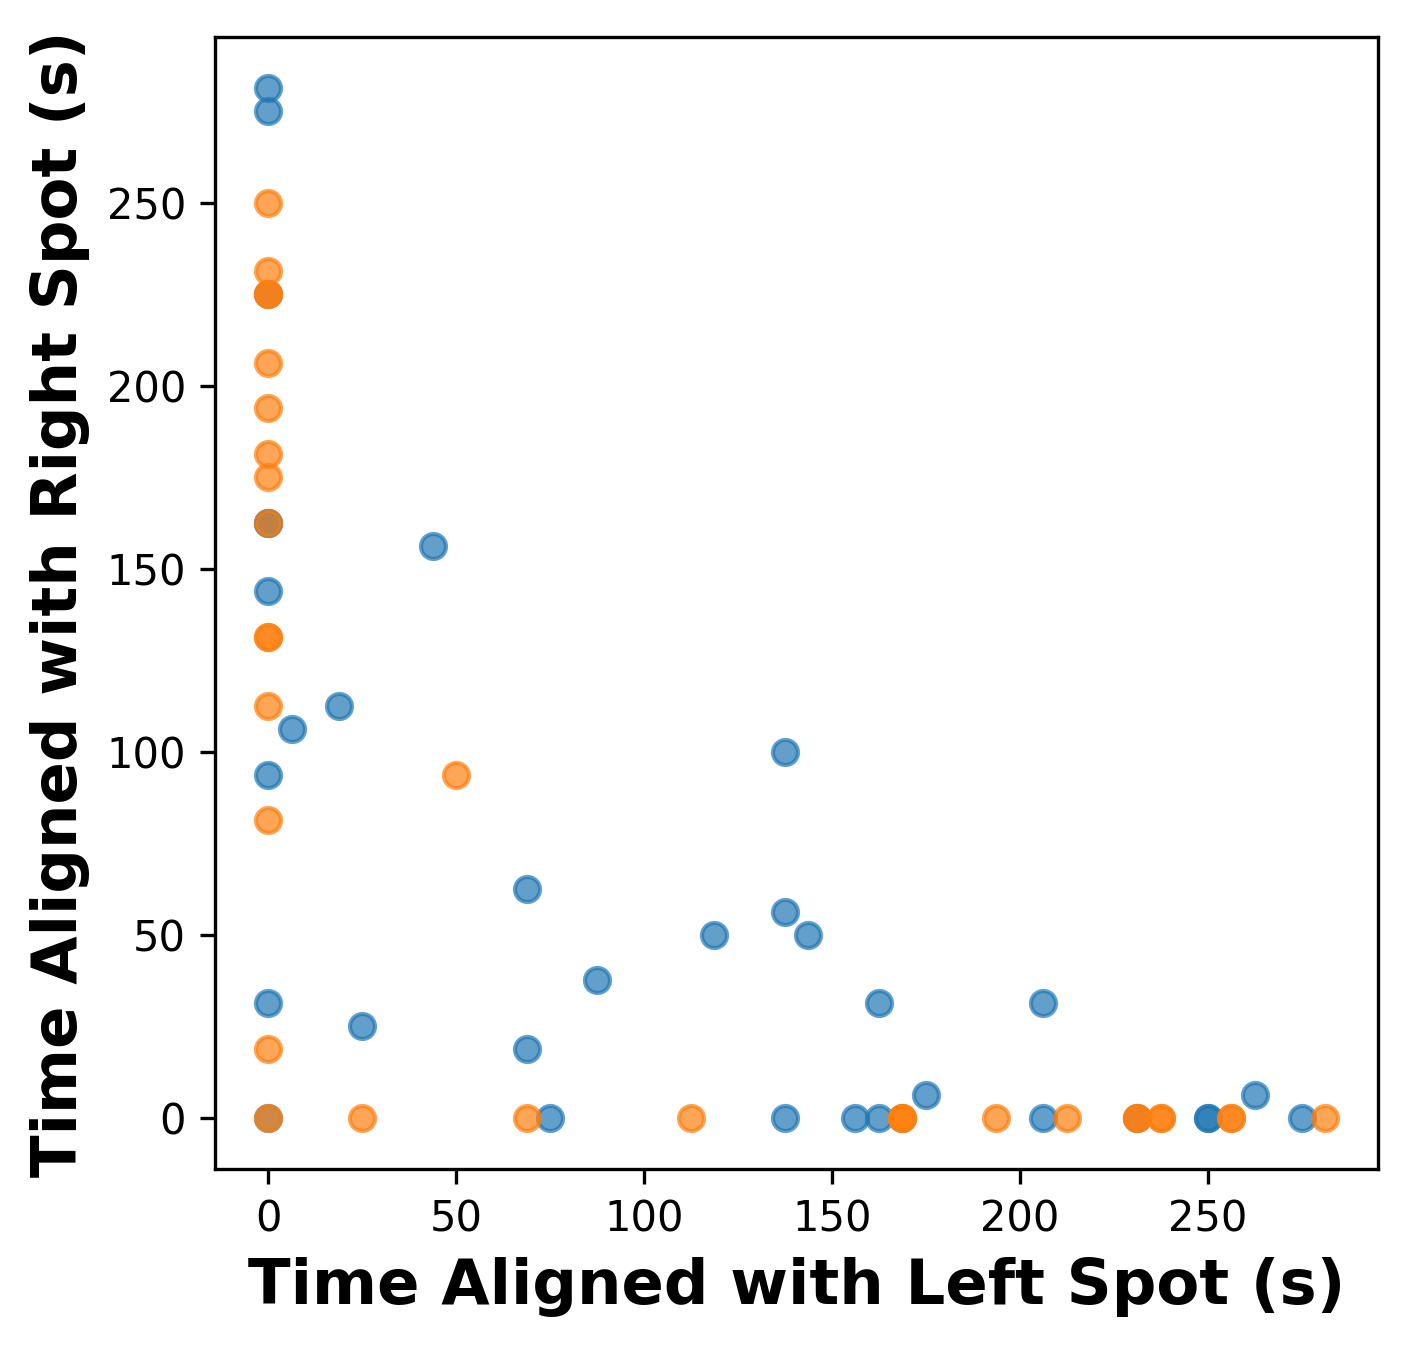

In [51]:
plt.figure(figsize = (5,5), dpi = 300)

right = np.abs(np.array(processed_angles_45)[:,10:] - math.pi/4) < RAD_CUTOFF
left = np.abs(np.array(processed_angles_45)[:,10:] + math.pi/4) < RAD_CUTOFF
#plt.imshow(right)
#plt.show()
#plt.imshow(left)
#plt.show()

R = 6.25*np.sum(right, axis = 1)
L = 6.25*np.sum(left, axis = 1)
plt.scatter(R, L, alpha = 0.7)

percent_time_aligned_with_left_45 = L/(R + L)

right = np.abs(np.array(processed_angles_90)[:,10:] - math.pi/2) < RAD_CUTOFF
left = np.abs(np.array(processed_angles_90)[:,10:] + math.pi/2) < RAD_CUTOFF
#plt.imshow(right)
#plt.show()
#plt.imshow(left)
#plt.show()


R = 6.25*np.sum(right, axis = 1)
L = 6.25*np.sum(left, axis = 1)
plt.scatter(R, L, alpha = 0.7)

percent_time_aligned_with_left_90 = L/(R + L)

plt.xlabel('Time Aligned with Left Spot (s)', fontweight = 'bold', fontsize = 15)
plt.ylabel('Time Aligned with Right Spot (s)', fontweight = 'bold', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

0.06451612903225806
0.48484848484848486
[0.08648236 0.17051776]


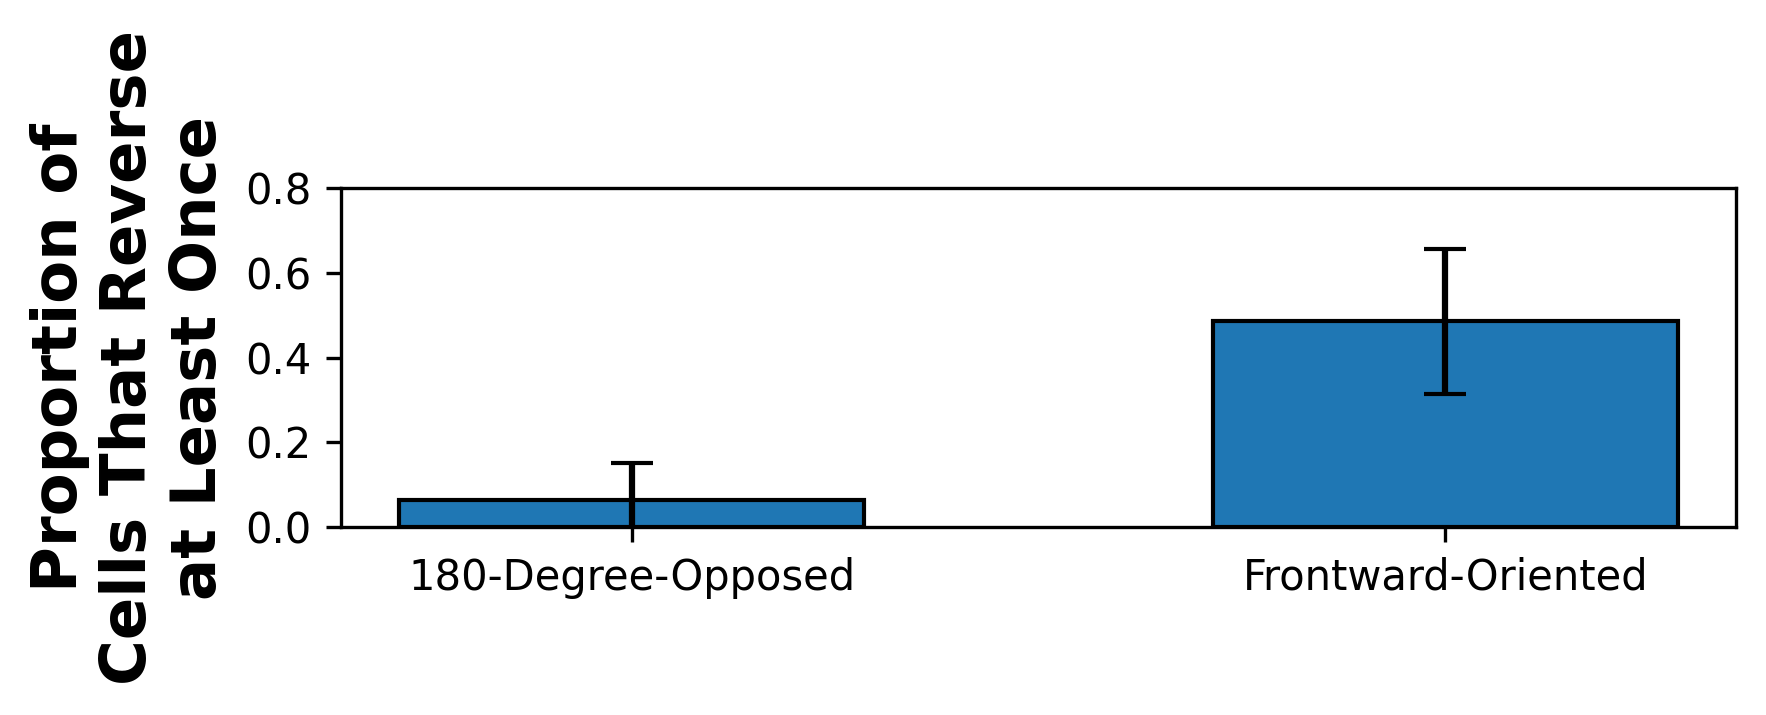

In [59]:
aligned_90 = (percent_time_aligned_with_left_90 != 1) & (percent_time_aligned_with_left_90 != 0)
print(np.sum(aligned_90)/len(aligned_90))

aligned_45 = (percent_time_aligned_with_left_45 != 1) & (percent_time_aligned_with_left_45 != 0)
print(np.sum(aligned_45)/len(aligned_45))

proportions_across_data = np.array([np.sum(aligned_90)/len(aligned_90), np.sum(aligned_45)/len(aligned_45)])
num_across_data = np.array([len(aligned_90), len(aligned_45)])

#Standard Error of Sample Proportion
sample_error = np.sqrt(proportions_across_data * (1 - proportions_across_data) / num_across_data)
percent_confidence_interval_95 = 1.96 * sample_error
print(percent_confidence_interval_95)

plt.figure(figsize = (6, 1.5), dpi = 300)
plt.bar([0, 1.4], proportions_across_data, yerr = percent_confidence_interval_95, capsize = 5, ec = 'k')
plt.ylim(0, 0.8)
plt.xticks([])
plt.xlim(-0.5, 1.9)
plt.ylabel('Proportion of\nCells That Reverse\nat Least Once', fontweight = 'bold', fontsize = 15)
plt.xticks([0, 1.4], ['180-Degree-Opposed', 'Frontward-Oriented'])
plt.show()